In [1]:
%matplotlib widget
import torch
from torch import manual_seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy,AUROC


import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

# from skimage.transform import resize

# torch.set_num_threads(3)

def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

SEED=1234
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
device='cpu'
DEVICE=device

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5)
        
        self.maxPooling2=nn.MaxPool2d(kernel_size=2)
        self.maxPooling4_0=nn.MaxPool2d(kernel_size=4)
        self.maxPooling4_1=nn.MaxPool2d(kernel_size=4)
#         self.adPooling=nn.AdaptiveAvgPool1d(256)
        
        self.fc1=nn.Linear(in_features=256,out_features=128)
        self.fc2=nn.Linear(in_features=128,out_features=64)
        self.out=nn.Linear(in_features=64,out_features=2)

    def forward(self,x):
        x=self.conv1(x)
        x=self.maxPooling4_0(x)
        x=F.relu(x)
        
        x=self.conv2(x)
        x=self.maxPooling4_1(x)
        x=F.relu(x)
        
        x=self.conv3(x)
        x=self.maxPooling2(x)
        x=F.relu(x)
        
        x=F.dropout(x)
        x=x.view(1,x.size()[0],-1) #stretch to 1d data
        #x=self.adPooling(x).squeeze()
        
        x=self.fc1(x)
        x=F.relu(x)
        
        x=self.fc2(x)
        x=F.relu(x)
        
        x=self.out(x)
        
        return x[0]


In [4]:
def train(lr,epochs,train_loader,val_loader,name_model,momentum=0.9,weight_decay=1e-3):
    metric = AUROC(task='binary', num_classes=2) 
    softmax = nn.Softmax(dim=1)
    
    training_accuracy = Accuracy(task='binary').to(DEVICE)
    val_accuracy = Accuracy(task='binary').to(DEVICE)

    manual_seed(1111)

    cnn_conf=Net()
    cnn_conf.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn_conf.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)


    loss_list_train=[]
    loss_list_val=[]
    acc_list_train=[]
    acc_list_va=[]
    

    min_loss = 1000000
#     last_loss = 1000000000
    models = []
    training_logs = []

    for training_ind in range(5):
        for epoch in range(epochs):  # loop over the dataset multiple times
            print(f' epoch {epoch+1} in {epochs}')
            t0=time.time()
            epoch_loss = 0.0
            epoch_loss_val=0.0
            batch_acc=[]
            batch_acc_val=[]

            auroc_train=[]
            auroc_val=[]

            pred_train=[]
            pred_val=[]
            true_labels_train=[]
            true_labels_val=[]

            for i, data in enumerate(train_loader):
                inputs, labels = data

                inputs = inputs.to(DEVICE,dtype=torch.float)
                labels = labels.type(torch.LongTensor)
                labels=labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = cnn_conf(inputs).squeeze()
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()        
                batch_acc.append(training_accuracy(predicted, labels).item())

                pred_train=np.concatenate((pred_train, softmax(outputs)[:,1].cpu().detach().numpy()))
                true_labels_train=np.concatenate((true_labels_train, labels.cpu().numpy()))

            auroc_train=metric(torch.tensor(pred_train),torch.tensor(true_labels_train).to(torch.int32))

            for i_v, data_val in enumerate(val_loader):
                inputs_val, labels_val = data_val

                inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
                labels_val = labels_val.type(torch.LongTensor)
                labels_val=labels_val.to(DEVICE)

                outputs_val = cnn_conf(inputs_val).squeeze()
                _, predicted_val = torch.max(outputs_val.data, 1)

                loss_val = criterion(outputs_val, labels_val)

                epoch_loss_val += loss_val.item()        
                batch_acc_val.append(val_accuracy(predicted_val, labels_val).item())


                pred_val=np.concatenate((pred_val, softmax(outputs_val)[:,1].cpu().detach().numpy()))
                true_labels_val=np.concatenate((true_labels_val, labels_val.cpu().detach().numpy()))

            if epoch_loss_val < min_loss:
                min_loss = epoch_loss_val
                save_model = type(cnn_conf)() # get a new instance
                save_model.load_state_dict(cnn_conf.state_dict()) # copy weights and stuff

                torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

            auroc_val=metric(torch.tensor(pred_val),torch.tensor(true_labels_val).to(torch.int32))

            epoch_acc=sum(batch_acc)/len(batch_acc)
            epoch_acc_val=sum(batch_acc_val)/len(batch_acc_val)

            print(f'epoch train loss: {epoch_loss} | epoch train acc {epoch_acc} | AUROC: {auroc_train}')
            print(f'epoch val loss: {epoch_loss_val} | epoch val acc {epoch_acc_val} | AUROC: {auroc_val}')
            print(f'time elapsed: {round(time.time()-t0,2)} s')

            loss_list_train.append(epoch_loss)
            loss_list_val.append(epoch_loss_val)
            acc_list_train.append(epoch_acc)
            acc_list_va.append(epoch_acc_val)

            epoch_loss = 0.0
            epoch_loss_val=0.0

    print('Finished Training')
    print()
    print('\t \t *******************')
    print()
    
    torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

    models.append(save_model)
    training_logs.append([acc_list_train, loss_list_train, acc_list_val, loss_list_val])
#     plt.plot(loss_list_train)
#     plt.plot(loss_list_val)
#     plt.plot([i*100 for i in acc_list_train])
#     plt.plot([i*100 for i in acc_list_va])
    return trained_models, [acc_list_train, loss_list_train, acc_list_val, loss_list_val]

In [5]:
cnn=Net()

In [5]:
# with open('confounder_train128.pkl', 'rb') as f:
#     confounder_train = pickle.load(f)
#     confounder_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_train]
# print('train')

# with open('confounder_val128.pkl', 'rb') as f:
#     confounder_val = pickle.load(f)
#     confounder_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_val]
# print('val')

with open('confounder_test128.pkl', 'rb') as f:
    confounder_test = pickle.load(f)
    confounder_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_test]
print('test')


test


In [7]:
len(confounder_val)

3000

<IPython.core.display.Javascript object>


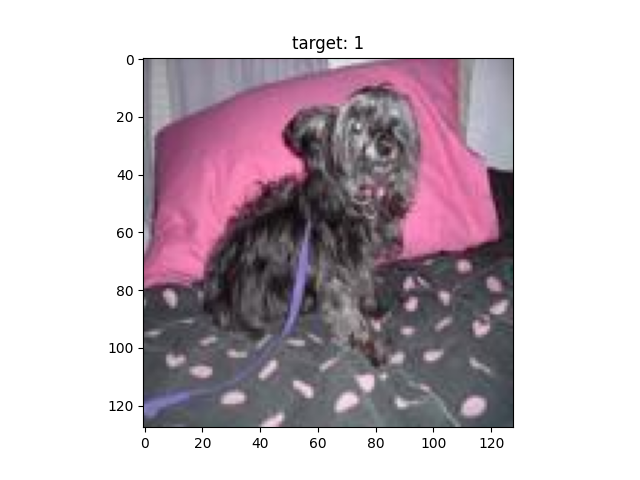

Text(0.5, 1.0, 'target: 1')

In [20]:
n=3000
plt.imshow(confounder_train[n][0].transpose(1,2,0))
plt.title('target: '+str(confounder_train[n][1]))

# Confounder

In [9]:
# batch_size=64
# manual_seed(0)
# confounder_train_loader = DataLoader(confounder_train,batch_size=batch_size, shuffle=True)
# confounder_val_loader = DataLoader(confounder_val,batch_size=batch_size, shuffle=True)
# confounder_hold_loader = DataLoader(confounder_test,batch_size=batch_size, shuffle=False)

# lr=0.005
# epochs=40

# conf_models, conf_logs = train(lr,epochs,confounder_train_loader,confounder_val_loader,'cnn_conf',weight_decay=0.005)

 epoch 1 in 40
epoch train loss: 65.11265748739243 | epoch train acc 0.5440492021276596 | AUROC: 0.5484753251075745
epoch val loss: 32.4638529419899 | epoch val acc 0.5459726440145615 | AUROC: 0.6855257749557495
time elapsed: 98.77 s
 epoch 2 in 40
epoch train loss: 64.74138337373734 | epoch train acc 0.5869348404255319 | AUROC: 0.6528586149215698
epoch val loss: 32.167096853256226 | epoch val acc 0.6264247716741359 | AUROC: 0.7427957653999329
time elapsed: 104.41 s
 epoch 3 in 40
epoch train loss: 63.73094844818115 | epoch train acc 0.6496564714198417 | AUROC: 0.7019999027252197
epoch val loss: 31.258008897304535 | epoch val acc 0.6690254553835443 | AUROC: 0.7606582045555115
time elapsed: 101.31 s
 epoch 4 in 40
epoch train loss: 59.12006962299347 | epoch train acc 0.6927637413461157 | AUROC: 0.74222731590271
epoch val loss: 28.580200612545013 | epoch val acc 0.6727298637653919 | AUROC: 0.7893733382225037
time elapsed: 113.43 s
 epoch 5 in 40
epoch train loss: 52.99434211850166 | epoc

KeyboardInterrupt: 

# Suppressor

In [11]:


# with open('suppressor_train128.pkl', 'rb') as f:
#     supressor_train = pickle.load(f)
#     supressor_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_train]
# print('train')

# with open('suppressor_validation128.pkl', 'rb') as f:
#     supressor_val = pickle.load(f)
#     supressor_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_val]
# print('val')

with open('suppressor_test128.pkl', 'rb') as f:
    supressor_test = pickle.load(f)
    supressor_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_test]
print('test')


test


In [ ]:
# supressor_train[0][0].shape

In [ ]:
# batch_size=64
# manual_seed(0)
# supressor_train_loader = DataLoader(supressor_train,batch_size=batch_size, shuffle=True)
# supressor_val_loader = DataLoader(supressor_val,batch_size=batch_size, shuffle=True)
# supressor_hold_loader = DataLoader(supressor_test,batch_size=batch_size, shuffle=False)

# lr=0.005
# epochs=33


# cnn_sup=train(lr,epochs,supressor_train_loader,supressor_val_loader,'cnn_sup',weight_decay=0.001)


In [ ]:
# cnn_sup

# No watermark

In [12]:


# with open('no_mark_train128.pkl', 'rb') as f:
#     no_mark_train = pickle.load(f)
#     no_mark_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_train]
# print('train')

# with open('no_mark_validation128.pkl', 'rb') as f:
#     no_mark_val = pickle.load(f)
#     no_mark_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_val]
# print('val')

with open('no_mark_test128.pkl', 'rb') as f:
    no_mark_test = pickle.load(f)
    no_mark_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_test]
print('test')


test


In [ ]:
# batch_size=64
# manual_seed(0)
# no_mark_train_loader = DataLoader(no_mark_train,batch_size=batch_size, shuffle=True)
# no_mark_val_loader = DataLoader(no_mark_val,batch_size=batch_size, shuffle=False)
# no_mark_test_loader = DataLoader(no_mark_test,batch_size=batch_size, shuffle=False)

# lr=0.005
# epochs=40
# cnn_no=train(lr,epochs,supressor_train_loader,supressor_val_loader,'cnn_no',weight_decay=0.003)


# AUROC

In [9]:
# true_labels=np.array([])

# for i_v, data_val in enumerate(confounder_hold_loader):
#     inputs_val, labels_val = data_val
#     inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
#     labels_val = labels_val.type(torch.LongTensor)
#     labels_val=labels_val.to(DEVICE)
    
#     true_labels=np.concatenate((true_labels, labels_val.cpu().numpy()))

# true_labels

NameError: name 'confounder_hold_loader' is not defined

### Train and Validation

In [2]:
def load_trained(path):
    model = Net()
    model.load_state_dict(torch.load(path,map_location=device))
    return model

def print_AUC(model, loader):

#     cnn_conf=load_trained(f'./cnn_conf_{model_ind}.pt').to(device)
#     cnn_sup=load_trained(f'./cnn_sup_{model_ind}.pt').to(device)
#     cnn_no=load_trained(f'./cnn_no_{model_ind}.pt').to(device)
    
    #models -> cnn_no; cnn_sup; cnn_conf

    softmax = nn.Softmax(dim=1)
    metric = AUROC(num_classes=2, task='binary')

#     model_conf_test_conf_pred=np.array([])
#     model_sup_test_conf_pred=np.array([])
#     model_no_test_conf_pred=np.array([])
    pred = np.array([])
    true_labels=np.array([])

    for i_v, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(DEVICE,dtype=torch.float)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(DEVICE)

        outputs = model(inputs).squeeze()
        out_pred=softmax(outputs)

        pred=np.concatenate((pred, out_pred[:,1].cpu().detach().numpy()))
#         model_sup_test_conf_pred=np.concatenate((model_sup_test_conf_pred, out_pred_sup[:,1].cpu().detach().numpy()))
#         model_no_test_conf_pred=np.concatenate((model_no_test_conf_pred, out_pred_no[:,1].cpu().detach().numpy()))
        true_labels=np.concatenate((true_labels, labels.cpu().numpy()))

#     print('model: confounder',metric(torch.tensor(model_conf_test_conf_pred),torch.tensor(true_labels).to(torch.int32)))
#     print('model: supressor',metric(torch.tensor(model_sup_test_conf_pred),torch.tensor(true_labels).to(torch.int32)))
#     print('model: no watermark',metric(torch.tensor(model_no_test_conf_pred),torch.tensor(true_labels).to(torch.int32)))
#     print()

#     l=[metric(torch.tensor(model_conf_test_conf_pred),torch.tensor(true_labels).to(torch.int32)),
#        metric(torch.tensor(model_sup_test_conf_pred),torch.tensor(true_labels).to(torch.int32)),
#        metric(torch.tensor(model_no_test_conf_pred),torch.tensor(true_labels).to(torch.int32))]
    return metric(torch.tensor(pred),torch.tensor(true_labels).to(torch.int32))

In [6]:
confounder_train_loader = DataLoader(confounder_train,batch_size=batch_size, shuffle=True)
confounder_val_loader = DataLoader(confounder_val,batch_size=batch_size, shuffle=True)

supressor_train_loader = DataLoader(supressor_train,batch_size=batch_size, shuffle=True)
supressor_val_loader = DataLoader(supressor_val,batch_size=batch_size, shuffle=True)

no_mark_train_loader = DataLoader(no_mark_train,batch_size=batch_size, shuffle=True)
no_mark_val_loader = DataLoader(no_mark_val,batch_size=batch_size, shuffle=True)

conf_train = []
conf_val = []

sup_train = []
sup_val = []

no_train = []
no_val = []

for i in range(10):
    model_conf = load_trained(f'./cnn_conf_{i}.pt').to(device)
    model_sup = load_trained(f'./cnn_sup_{i}.pt').to(device)
    model_no = load_trained(f'./cnn_no_{i}.pt').to(device)
    
    conf_train.append(print_AUC(model_conf, confounder_train_loader))
    conf_val.append(print_AUC(model_conf, confounder_val_loader))
    
    sup_train.append(print_AUC(model_sup, supressor_train_loader))
    sup_val.append(print_AUC(model_sup, supressor_val_loader))
    
    no_train.append(print_AUC(model_no, no_mark_train_loader))
    no_val.append(print_AUC(model_no, no_mark_val_loader))
    

NameError: name 'confounder_train' is not defined

In [35]:
torch.mean(torch.tensor(conf_train)), torch.mean(torch.tensor(conf_val))

(tensor(0.9805), tensor(0.9352))

In [37]:
torch.mean(torch.tensor(sup_train)), torch.mean(torch.tensor(sup_val))

(tensor(0.9891), tensor(0.9226))

In [36]:
torch.mean(torch.tensor(no_train)), torch.mean(torch.tensor(no_val))

(tensor(0.9943), tensor(0.9471))

In [5]:
with open('auroc_conf.pickle', 'rb') as f:
    auroc_conf = pickle.load(f)

with open('auroc_sup.pickle', 'rb') as f:
    auroc_sup = pickle.load(f)

with open('auroc_no.pickle', 'rb') as f:
    auroc_no = pickle.load(f)

with open('conf_labels.pickle', 'rb') as f:
    labels_conf = pickle.load(f)

In [10]:
auroc_conf

[array([0.97721672, 0.10912072, 0.99842119, ..., 0.22333236, 0.99900836,
        0.07231517]),
 array([0.88604712, 0.00207852, 0.99821067, ..., 0.45749605, 0.00866784,
        0.02422673]),
 array([0.15929373, 0.96062446, 0.09566309, ..., 0.72254902, 0.00376806,
        0.93935961])]

In [13]:
labels_conf

array([1., 0., 1., ..., 0., 1., 0.])

In [4]:
with open('auroc_results_split_0.pickle', 'rb') as f:
    auroc_results_0 = pickle.load(f)

with open('auroc_results_split_1.pickle', 'rb') as f:
    auroc_results_1 = pickle.load(f)

In [5]:
auroc_results_0

[[[tensor(0.9668), tensor(0.9821), tensor(0.9600)],
  [tensor(0.9690), tensor(0.9744), tensor(0.9532)],
  [tensor(0.9643), tensor(0.9805), tensor(0.9534)],
  [tensor(0.9618), tensor(0.9802), tensor(0.9563)],
  [tensor(0.9645), tensor(0.9816), tensor(0.9373)],
  [tensor(0.9616), tensor(0.9770), tensor(0.9544)],
  [tensor(0.9602), tensor(0.9593), tensor(0.9405)],
  [tensor(0.9653), tensor(0.9755), tensor(0.9551)],
  [tensor(0.9724), tensor(0.9703), tensor(0.9595)],
  [tensor(0.9650), tensor(0.9817), tensor(0.9495)]],
 [[tensor(0.9185), tensor(0.9774), tensor(0.9493)],
  [tensor(0.9055), tensor(0.9665), tensor(0.9496)],
  [tensor(0.8945), tensor(0.9790), tensor(0.9502)],
  [tensor(0.8927), tensor(0.9780), tensor(0.9496)],
  [tensor(0.8995), tensor(0.9786), tensor(0.9503)],
  [tensor(0.8799), tensor(0.9784), tensor(0.9538)],
  [tensor(0.8908), tensor(0.9650), tensor(0.9510)],
  [tensor(0.8978), tensor(0.9749), tensor(0.9587)],
  [tensor(0.9070), tensor(0.9702), tensor(0.9552)],
  [tensor(0

In [6]:
auroc_results_0[0].extend(auroc_results_1[0])

In [7]:
auroc_results_0

[[[tensor(0.9668), tensor(0.9821), tensor(0.9600)],
  [tensor(0.9690), tensor(0.9744), tensor(0.9532)],
  [tensor(0.9643), tensor(0.9805), tensor(0.9534)],
  [tensor(0.9618), tensor(0.9802), tensor(0.9563)],
  [tensor(0.9645), tensor(0.9816), tensor(0.9373)],
  [tensor(0.9616), tensor(0.9770), tensor(0.9544)],
  [tensor(0.9602), tensor(0.9593), tensor(0.9405)],
  [tensor(0.9653), tensor(0.9755), tensor(0.9551)],
  [tensor(0.9724), tensor(0.9703), tensor(0.9595)],
  [tensor(0.9650), tensor(0.9817), tensor(0.9495)],
  [tensor(0.9631), tensor(0.9755), tensor(0.9398)],
  [tensor(0.9626), tensor(0.9682), tensor(0.9004)],
  [tensor(0.9627), tensor(0.9754), tensor(0.9155)],
  [tensor(0.9691), tensor(0.9691), tensor(0.9122)],
  [tensor(0.9729), tensor(0.9731), tensor(0.8842)],
  [tensor(0.9637), tensor(0.9678), tensor(0.9613)],
  [tensor(0.9675), tensor(0.9611), tensor(0.9515)],
  [tensor(0.9612), tensor(0.9695), tensor(0.9439)],
  [tensor(0.9660), tensor(0.9722), tensor(0.9442)],
  [tensor(0.

In [8]:
lst = []
lst.extend(auroc_results_0[0])
print(lst)

[[tensor(0.9668), tensor(0.9821), tensor(0.9600)], [tensor(0.9690), tensor(0.9744), tensor(0.9532)], [tensor(0.9643), tensor(0.9805), tensor(0.9534)], [tensor(0.9618), tensor(0.9802), tensor(0.9563)], [tensor(0.9645), tensor(0.9816), tensor(0.9373)], [tensor(0.9616), tensor(0.9770), tensor(0.9544)], [tensor(0.9602), tensor(0.9593), tensor(0.9405)], [tensor(0.9653), tensor(0.9755), tensor(0.9551)], [tensor(0.9724), tensor(0.9703), tensor(0.9595)], [tensor(0.9650), tensor(0.9817), tensor(0.9495)], [tensor(0.9631), tensor(0.9755), tensor(0.9398)], [tensor(0.9626), tensor(0.9682), tensor(0.9004)], [tensor(0.9627), tensor(0.9754), tensor(0.9155)], [tensor(0.9691), tensor(0.9691), tensor(0.9122)], [tensor(0.9729), tensor(0.9731), tensor(0.8842)], [tensor(0.9637), tensor(0.9678), tensor(0.9613)], [tensor(0.9675), tensor(0.9611), tensor(0.9515)], [tensor(0.9612), tensor(0.9695), tensor(0.9439)], [tensor(0.9660), tensor(0.9722), tensor(0.9442)], [tensor(0.9575), tensor(0.9719), tensor(0.9273)]]

In [9]:
print('conf data: ', torch.mean(torch.tensor(auroc_results[0]), axis=0))
print('sup data: ', torch.mean(torch.tensor(auroc_results[1]), axis=0))
print('no mark data: ', torch.mean(torch.tensor(auroc_results[2]), axis=0))

NameError: name 'auroc_results' is not defined

In [8]:
print('conf data: ', torch.mean(torch.tensor(auroc_results[0]), axis=0))
print('sup data: ', torch.mean(torch.tensor(auroc_results[1]), axis=0))
print('no mark data: ', torch.mean(torch.tensor(auroc_results[2]), axis=0))

conf data:  tensor([0.9651, 0.9763, 0.9519])
sup data:  tensor([0.8989, 0.9752, 0.9527])
no mark data:  tensor([0.9413, 0.9790, 0.9876])


In [9]:
conf_data_res = []
sup_data_res = []
no_data_res = []

for i in range(5):
    with open(f'auroc_results_split_{i}.pickle', 'rb') as f:
        auroc_results = pickle.load(f)

    conf_data_res.extend(auroc_results[0])
    sup_data_res.extend(auroc_results[1])
    no_data_res.extend(auroc_results[2])
    
    # print("SPLIT: ", i)
print('conf data: ', torch.mean(torch.tensor(conf_data_res), axis=0))
print('sup data: ', torch.mean(torch.tensor(sup_data_res), axis=0))
print('no mark data: ', torch.mean(torch.tensor(no_data_res), axis=0))
print('\nSTD\n')
print('conf data: ', torch.std(torch.tensor(conf_data_res), axis=0))
print('sup data: ', torch.std(torch.tensor(sup_data_res), axis=0))
print('no mark data: ', torch.std(torch.tensor(no_data_res), axis=0))

conf data:  tensor([0.9278, 0.8848, 0.8584])
sup data:  tensor([0.8186, 0.8847, 0.8682])
no mark data:  tensor([0.8746, 0.8925, 0.9036])

STD

conf data:  tensor([0.0048, 0.0136, 0.0257])
sup data:  tensor([0.0148, 0.0083, 0.0106])
no mark data:  tensor([0.0103, 0.0091, 0.0085])


In [20]:
with open('./aurocs/auroc_conf_0.pickle', 'rb') as f:
    auroc_conf_0 = pickle.load(f)

lst = []

lst.extend(auroc_conf_0[0])
lst.extend(auroc_conf_0[0])
print(len(lst))

18000


In [27]:
# dct[model][data]
preds = {
    'conf': {'conf': [], 'sup': [], 'no': [] },
    'sup': {'conf': [], 'sup': [], 'no': [] },
    'no': {'conf': [], 'sup': [], 'no': [] } 
}

labels = {
    'conf': [],
    'sup': [],
    'no': [] 
}


for i in range(5):
    with open(f'./aurocs/auroc_conf_{i}.pickle', 'rb') as f:
        preds_conf = pickle.load(f)

    with open(f'./aurocs/auroc_sup_{i}.pickle', 'rb') as f:
        preds_sup = pickle.load(f)

    with open(f'./aurocs/auroc_no_{i}.pickle', 'rb') as f:
        preds_no = pickle.load(f)

    
    with open(f'./aurocs/conf_labels_{i}.pickle', 'rb') as f:
        labels_conf = pickle.load(f)

    with open(f'./aurocs/sup_labels_{i}.pickle', 'rb') as f:
        labels_sup = pickle.load(f)

    with open(f'./aurocs/no_labels_{i}.pickle', 'rb') as f:
        labels_no = pickle.load(f)

    
    labels_dataset = [labels_conf, labels_sup, labels_no] 
    pred_model = [preds_conf, preds_sup, preds_no]

    for j, (model, models) in enumerate(preds.items()):
        for k, (data, results) in enumerate(models.items()):
            preds[model][data].extend(pred_model[j][k])
            
        labels[model].extend(labels_dataset[j])


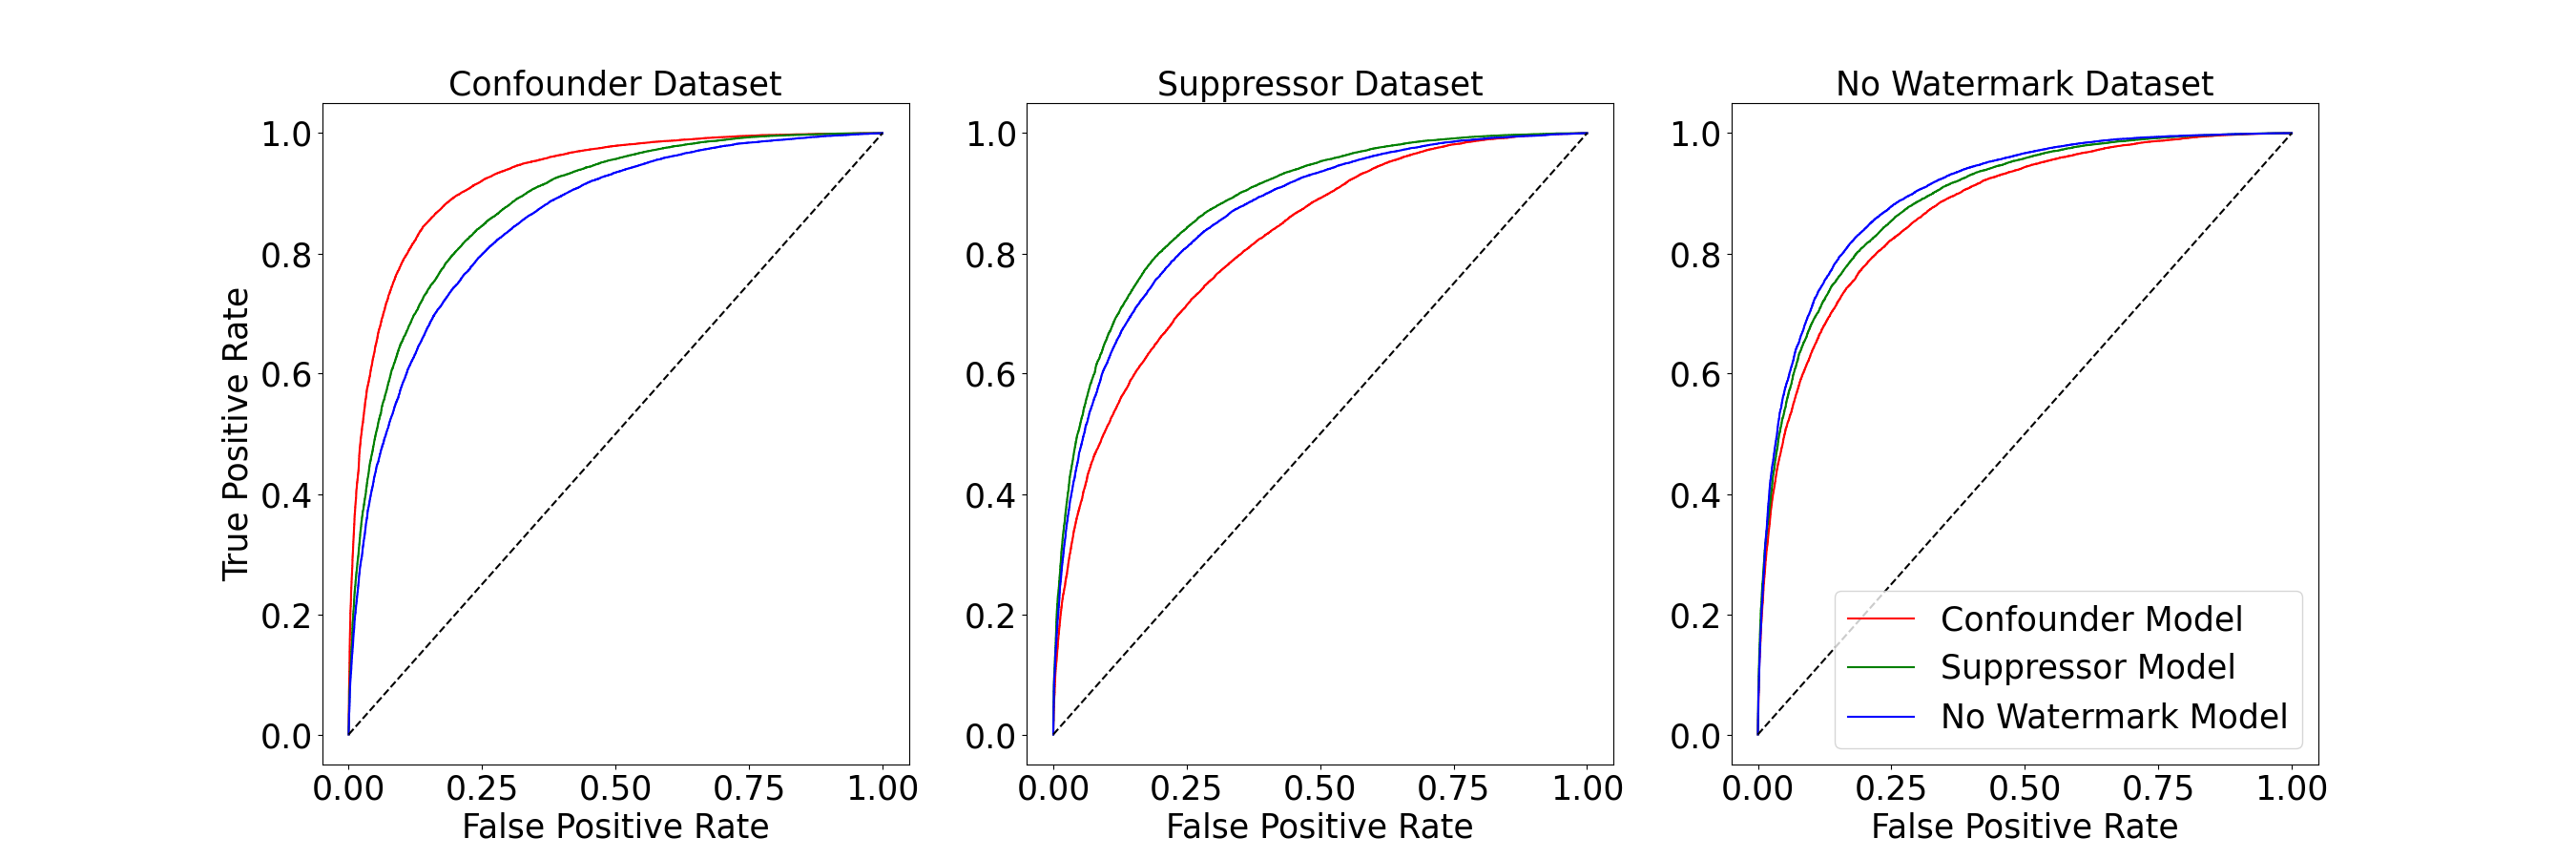

In [32]:
from sklearn.metrics import roc_curve

fig, axs = plt.subplots(1, 3, figsize=(27, 9))

models = ['Confounder', 'Suppressor', 'No Watermark']
colours = ['r', 'g', 'b']

for i, (test_labels, results) in enumerate([[labels['conf'], [preds['conf']['conf'], preds['sup']['conf'], preds['no']['conf']]], [labels['sup'], [preds['conf']['sup'], preds['sup']['sup'], preds['no']['sup']]], [labels['no'], [preds['conf']['no'], preds['sup']['no'], preds['no']['no']]]]):
    for j, result in enumerate(results):
        fpr, tpr, _ = roc_curve(test_labels, result)
        axs[i].plot(fpr, tpr, color=colours[j], label=f'{models[j]} Model')
        
        # axs[i,j].axis('off')
    axs[i].set_title(f'{models[i]} Dataset')
    axs[i].set_xlabel('False Positive Rate')
    axs[i].plot([0, 1], [0, 1], 'k--') 

axs[0].set_ylabel('True Positive Rate')

# Add legend
axs[2].legend(loc='lower right')

plt.savefig('./figures/roc_curves.png', bbox_inches='tight')
plt.savefig('./figures/roc_curves_hires.png', bbox_inches='tight', dpi=300)

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(labels_conf, auroc_conf[0])
fpr_1, tpr_1, _ = roc_curve(labels_conf, auroc_sup[0])
fpr_2, tpr_2, _ = roc_curve(labels_conf, auroc_no[0])

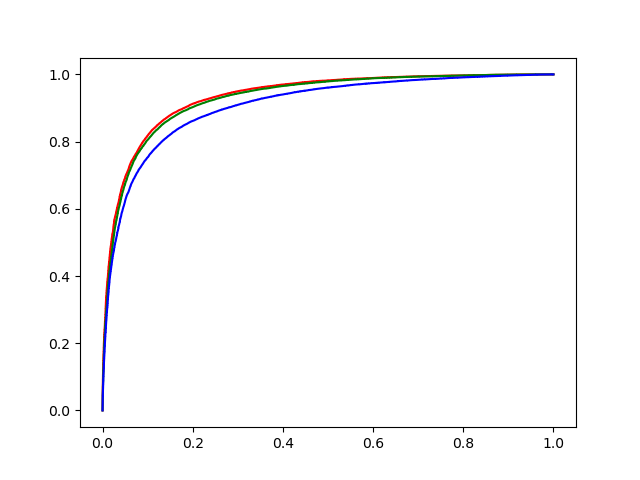

In [15]:
fig, axs = plt.subplots()
axs.plot(fpr, tpr, color='r')
axs.plot(fpr_1, tpr_1, color='g')
axs.plot(fpr_2, tpr_2, color='b')

### Test AUROC

In [5]:
def load_trained(path):
    model = Net()
    model.load_state_dict(torch.load(path,map_location=device))
    return model

def print_AUC(loader, model_ind=0):

    cnn_conf=load_trained(f'./models/cnn_conf_{model_ind}.pt').to(device)
    cnn_sup=load_trained(f'./models/cnn_sup_{model_ind}.pt').to(device)
    cnn_no=load_trained(f'./models/cnn_no_{model_ind}.pt').to(device)
    
    #models -> cnn_no; cnn_sup; cnn_conf

    softmax = nn.Softmax(dim=1)
    # metric = AUROC(num_classes=2, task='binary')

    metric_conf = AUROC(num_classes=2, task='binary')
    metric_sup = AUROC(num_classes=2, task='binary')
    metric_no = AUROC(num_classes=2, task='binary')

    # model_conf_test_conf_pred=np.array([])
    # model_sup_test_conf_pred=np.array([])
    # model_no_test_conf_pred=np.array([])
    # true_labels=np.array([])

    for i_v, data_val in enumerate(loader):
        inputs_val, labels_val = data_val
        inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
        labels_val = labels_val.type(torch.LongTensor)
        labels_val=labels_val.to(DEVICE)

        outputs_conf = cnn_conf(inputs_val).squeeze()
        outputs_sup = cnn_sup(inputs_val).squeeze()
        outputs_no = cnn_no(inputs_val).squeeze()

        out_pred_conf=softmax(outputs_conf)
        out_pred_sup=softmax(outputs_sup)
        out_pred_no=softmax(outputs_no)

        acc_conf = metric_conf(out_pred_conf[:,1], labels_val)
        acc_sup = metric_sup(out_pred_sup[:,1], labels_val)
        acc_no = metric_no(out_pred_no[:,1], labels_val)

    acc_conf = metric_conf.compute()
    acc_sup = metric_sup.compute()
    acc_no = metric_no.compute()
    
        # model_conf_test_conf_pred=np.concatenate((model_conf_test_conf_pred, out_pred_conf[:,1].cpu().detach().numpy()))
        # model_sup_test_conf_pred=np.concatenate((model_sup_test_conf_pred, out_pred_sup[:,1].cpu().detach().numpy()))
        # model_no_test_conf_pred=np.concatenate((model_no_test_conf_pred, out_pred_no[:,1].cpu().detach().numpy()))
        # true_labels=np.concatenate((true_labels, labels_val.cpu().numpy()))

    print('model: confounder',acc_conf)
    print('model: supressor',acc_sup)
    print('model: no watermark',acc_no)
    print()

    l=[acc_conf,
       acc_sup,
       acc_no]
    return l


In [8]:
batch_size=64
confounder_test_loader = DataLoader(confounder_test,batch_size=batch_size, shuffle=False)
supressor_test_loader = DataLoader(supressor_test,batch_size=batch_size, shuffle=False)
no_mark_test_loader = DataLoader(no_mark_test,batch_size=batch_size, shuffle=False)

confounder_data_results = []
suppressor_data_results = []
no_mark_data_results = []

for i in range(2):
    print(f'MODEL {i}')
    print('confounder data:')
    confounder_data_results.append(print_AUC(confounder_test_loader, i))
    print()
    print('suppressor data:')
    suppressor_data_results.append(print_AUC(supressor_test_loader, i))
    print()
    print('no watermark data:')
    no_mark_data_results.append(print_AUC(no_mark_test_loader, i))
    print()

MODEL 0
confounder data:


NameError: name 'Net' is not defined

In [59]:
confounder_data_results

NameError: name 'confounder_data_results' is not defined

In [ ]:
confounder_data_results

In [23]:
# Mean AUROC (horizontal test data, vertical model)

In [16]:
torch.mean(torch.tensor(confounder_data_results), axis=0)

tensor([0.9424, 0.9304, 0.9043])

In [17]:
torch.mean(torch.tensor(suppressor_data_results), axis=0)

tensor([0.8418, 0.9274, 0.9105])

In [18]:
torch.mean(torch.tensor(no_mark_data_results), axis=0)

tensor([0.8972, 0.9356, 0.9521])

In [21]:
# Std dev

In [20]:
torch.std(torch.tensor(confounder_data_results), axis=0)

tensor([0.0034, 0.0096, 0.0142])

In [24]:
torch.std(torch.tensor(suppressor_data_results), axis=0)

tensor([0.0178, 0.0055, 0.0059])

In [25]:
torch.std(torch.tensor(no_mark_data_results), axis=0)

tensor([0.0066, 0.0053, 0.0035])

# Heatmaps

In [3]:
import os
# import nibabel as nib

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import time
import pickle
import random

from scipy import ndimage

# from skimage.filters import threshold_otsu
# from skimage.measure import label, regionprops
# from skimage import transform
# from skimage.transform import resize
# import skimage.exposure as skie

import ot

import torch
from torch import manual_seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
# from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

import gc 
from PIL import Image 

torch.cuda.is_available()

torch.set_num_threads(3)



from captum.attr import IntegratedGradients, Saliency, DeepLift, DeepLiftShap, GradientShap  
from captum.attr import GuidedBackprop, Deconvolution, LRP, InputXGradient, Lime

from captum._utils.models.linear_model import SkLearnLasso
# lime = Lime(net, interpretable_model=SkLearnLasso(alpha=0.0))

# from zennit.composites import EpsilonPlusFlat
from zennit.composites import EpsilonAlpha2Beta1


# device='cuda:6'
device='cpu'
def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val




In [4]:
#load models
from captum.attr import Saliency, DeepLift, InputXGradient,DeepLiftShap, GradientShap, GuidedBackprop, Deconvolution, LRP

def load_model(path):
    model = Net()
    
    model.load_state_dict(torch.load(path,map_location=device))
    model.eval()
    model.zero_grad()
    
    model.relu=nn.ReLU(inplace=False)
    return model


In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5)
        
        self.maxPooling2=nn.MaxPool2d(kernel_size=2)
        self.maxPooling4_0=nn.MaxPool2d(kernel_size=4)
        self.maxPooling4_1=nn.MaxPool2d(kernel_size=4)
#         self.adPooling=nn.AdaptiveAvgPool1d(256)
        
        self.fc1=nn.Linear(in_features=256,out_features=128)
        self.fc2=nn.Linear(in_features=128,out_features=64)
        self.out=nn.Linear(in_features=64,out_features=2)

    def forward(self,x):
        x=self.conv1(x)
        x=self.maxPooling4_0(x)
        x=F.relu(x)
        
        x=self.conv2(x)
        x=self.maxPooling4_1(x)
        x=F.relu(x)
        
        x=self.conv3(x)
        x=self.maxPooling2(x)
        x=F.relu(x)
        
        x=F.dropout(x)
        x=x.view(1,x.size()[0],-1) #stretch to 1d data
        #x=self.adPooling(x).squeeze()
        
        x=self.fc1(x)
        x=F.relu(x)
        
        x=self.fc2(x)
        x=F.relu(x)
        
        x=self.out(x)
        
        return x[0]



model_confounder=load_model('./models/cnn_confounder_0_0.pt').to(device)
model_supressor=load_model('./models/cnn_suppressor_0_0.pt').to(device)
model_no_water=load_model('./models/cnn_no_watermark_0_0.pt').to(device)


In [6]:
split = 0
with open(f'./artifacts/split_{split}_no_watermark_test.pkl', 'rb') as f:
    no_watermark_dataset, labels_test_no, _ = pickle.load(f)
    no_watermark_dataset = [[rescale_values(x,1,0).transpose(2,0,1),labels_test_no.flatten()[i]] for i,x in enumerate(no_watermark_dataset)]

with open(f'./artifacts/split_{split}_all_watermark_test.pkl', 'rb') as f:
    watermark_dataset, labels_test, _ = pickle.load(f)
    watermark_dataset = [[rescale_values(x,1,0).transpose(2,0,1),labels_test.flatten()[i]] for i,x in enumerate(watermark_dataset)]

(3, 128, 128)
torch.Size([1, 3, 128, 128])


<Figure size 640x480 with 0 Axes>

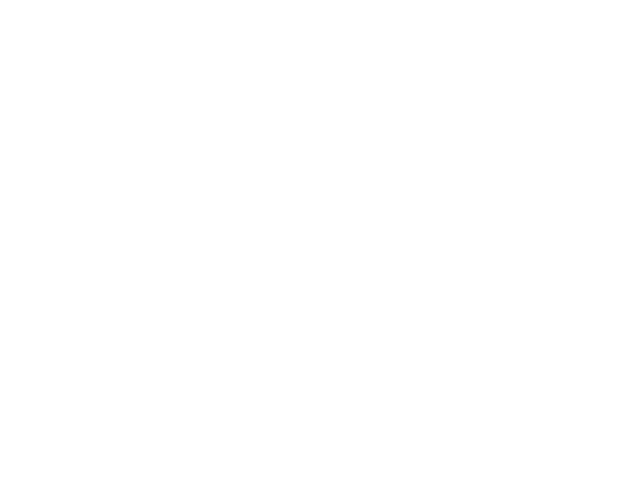

In [8]:
n=2
test_img = no_watermark_dataset[n][0]
print(test_img.shape)
target=no_watermark_dataset[n][1]
# test_img = supressor_test[n][0]
# target=supressor_test[n][1]
transformed_img=torch.tensor(test_img)
input_image = transformed_img.unsqueeze(0)
print(input_image.shape)
data=input_image.to(device,dtype=torch.float)

plt.imshow(input_image.squeeze().to('cpu').numpy().transpose(1,2,0))
plt.figure()
# grayscale_att_lrp=lrp(data,model_supressor,1,device)
# plt.imshow(abs(grayscale_att_lrp))

(3, 128, 128)
torch.Size([1, 3, 128, 128])


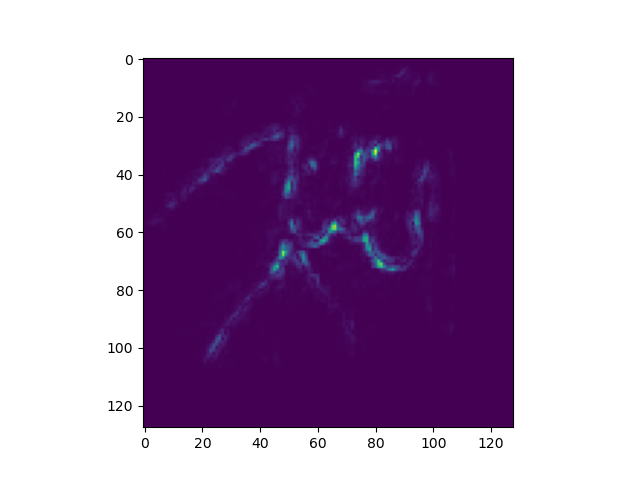

In [9]:
def lrp(data,model,target,device):
    # create a composite instance
    #composite = EpsilonPlusFlat()
    composite = EpsilonAlpha2Beta1()

    # use the following instead to ignore bias for the relevance
    # composite = EpsilonPlusFlat(zero_params='bias')

    # make sure the input requires a gradient
    data.requires_grad = True

    # compute the output and gradient within the composite's context
    with composite.context(model) as modified_model:
        modified_model=modified_model.to(device)
        output = modified_model(data.to(device))
        # gradient/ relevance wrt. class/output 0
        output.backward(gradient=torch.eye(2)[[target]].to(device))
        # relevance is not accumulated in .grad if using torch.autograd.grad
        # relevance, = torch.autograd.grad(output, input, torch.eye(10)[[0])

    # gradient is accumulated in input.grad
    att=abs(data.grad.detach().cpu().squeeze().numpy().transpose(1,2,0))

    rgb_weights = [0.2989, 0.5870, 0.1140]
    grayscale_att_lrp = np.dot(att[...,:3], rgb_weights)

    
    return grayscale_att_lrp
    



n=2
test_img = no_watermark_dataset[n][0]
print(test_img.shape)
target=no_watermark_dataset[n][1]
# test_img = supressor_test[n][0]
# target=supressor_test[n][1]
transformed_img=torch.tensor(test_img)
input_image = transformed_img.unsqueeze(0)
print(input_image.shape)
data=input_image.to(device,dtype=torch.float)

plt.imshow(input_image.squeeze().to('cpu').numpy().transpose(1,2,0))
plt.figure()
grayscale_att_lrp=lrp(data,model_supressor,1,device)
plt.imshow(abs(grayscale_att_lrp))

In [10]:
def plot_atts(data,model,target):
    DEVICE = 'cpu'
    # data is a tensor of shape torch.Size([1, 3, 128, 128])
    # model is
    # target is an integer
    
    torch.manual_seed(SEED)
    out=model(data)
    Y_probs = F.softmax(out[0], dim=-1)
    target = int(target)
    # with torch.no_grad():
    ig_att = np.transpose(IntegratedGradients(model).attribute(data, target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    sal_att = np.transpose(Saliency(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    gradshap_att = np.transpose(GradientShap(model).attribute(data,target=target, baselines=torch.zeros(data.shape).to(device)).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    backprop_att = np.transpose(GuidedBackprop(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    ix_att = np.transpose(InputXGradient(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    deconv_att = np.transpose(Deconvolution(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    lrp_att=np.transpose(LRP(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    lime_att=np.transpose(Lime(model,interpretable_model=SkLearnLasso(alpha=0.01)).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    lrp_ab = lrp(data, model, target, DEVICE)
    
    rgb_weights = [0.2989, 0.5870, 0.1140]
    
    grayscale_att_deconv = np.dot(deconv_att[...,:3], rgb_weights)
    grayscale_att_ix = np.dot(ix_att[...,:3], rgb_weights)
    grayscale_att_backprp = np.dot(backprop_att[...,:3], rgb_weights)
    grayscale_att_shap = np.dot(gradshap_att[...,:3], rgb_weights)
    grayscale_att_sal = np.dot(sal_att[...,:3], rgb_weights)
    grayscale_att_ig = np.dot(ig_att[...,:3], rgb_weights)
    grayscale_att_lrp = np.dot(lrp_att[...,:3], rgb_weights)
    grayscale_att_lime = np.dot(lime_att[...,:3], rgb_weights)
    
    
    atts={'deconv':abs(grayscale_att_deconv),'saliency':abs(grayscale_att_sal),'gradients':abs(grayscale_att_ig),
          'shap':abs(grayscale_att_shap),'backprop':abs(grayscale_att_backprp),'ix':abs(grayscale_att_ix),
          'lrp':abs(grayscale_att_lrp), 'lime': abs(grayscale_att_lime), 'lrp-ab': abs(lrp_ab)}
    
    
#     print(grayscale_att_sal.shape)
#     plt.figure(figsize=(20,10))
#     plt.subplot(1,3,1)
#     plt.imshow(test_img.transpose(1,2,0))
#     plt.subplot(1,3,2)
#     plt.imshow(resize(grayscale_att_sal,(128,128)),cmap='inferno')
#     plt.subplot(1,3,3)
#     plt.imshow(test_img.transpose(1,2,0))
#     plt.imshow(resize(grayscale_att_sal,(128,128)),cmap='inferno',alpha=0.7)


    return atts,Y_probs

In [13]:
# def plots(n, device, model_ind=0):
#     #images
#     watermark_image=watermark_dataset[n][0]    
#     data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
#     no_watermark_image=no_watermark_dataset[n][0]
#     data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
#     #target (same for both images)
#     target=watermark_dataset[n][1]
    
#     #models
# #     model_conf = model_confounder.to(device)
# #     model_sup = model_supressor.to(device)
# #     model_no = model_no_water.to(device)

#     model_conf=load_trained(f'./cnn_conf_{model_ind}.pt').to(device)
#     model_sup=load_trained(f'./cnn_sup_{model_ind}.pt').to(device)
#     model_no=load_trained(f'./cnn_no_{model_ind}.pt').to(device)
    
#     #plots 
#     fig, axs = plt.subplots(6, 7,figsize=(16, 22))
#     plt.subplots_adjust(wspace=0.05, hspace=0.05)
#     font_size=15
#     plt.rcParams['font.size'] = font_size
#     plt.rc('axes', titlesize=font_size) #title
    
#     atts={'watermark_conf':plot_atts(data_watermark,model_conf,target),
#           'watermark_sup':plot_atts(data_watermark,model_sup,target),
#           'watermark_no':plot_atts(data_watermark,model_no,target),
#           'no_watermark_conf':plot_atts(data_no_watermark,model_conf,target),
#           'no_watermark_sup':plot_atts(data_no_watermark,model_sup,target),
#           'no_watermark_no':plot_atts(data_no_watermark,model_no,target)}
    
    
#     original_imgs=[watermark_image,no_watermark_image,
#                    watermark_image,no_watermark_image,
#                    watermark_image,no_watermark_image]
    
#     images=[atts['watermark_conf'][0],atts['no_watermark_conf'][0],
#             atts['watermark_sup'][0],atts['no_watermark_sup'][0],
#             atts['watermark_no'][0],atts['no_watermark_no'][0]]
    
#     probs=[atts['watermark_conf'][1],atts['no_watermark_conf'][1],
#             atts['watermark_sup'][1],atts['no_watermark_sup'][1],
#             atts['watermark_no'][1],atts['no_watermark_no'][1]]
    
#     labels=['Model Confounder','Model Confounder',
#            'Model Supressor','Model Supressor',
#            'Model No Watermark','Model No Watermark']
    
#     cmap='cubehelix'
#     cmap='hot'
#     cmap='inferno'
#     cmap='CMRmap'

#     for i in range(7):
#         for j in range(6):
#             axs[j,i].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
            
#             axs[j,0].imshow(original_imgs[j].transpose(1,2,0))
#             axs[j,1].imshow(images[j]['deconv'],cmap=cmap)
#             axs[j,2].imshow(images[j]['gradients'],cmap=cmap)
#             axs[j,3].imshow(images[j]['shap'],cmap=cmap)
#             axs[j,4].imshow(images[j]['lrp'],cmap=cmap)
#             axs[j,5].imshow(images[j]['lime'],cmap=cmap)
#             axs[j,6].imshow(images[j]['lrp-ab'],cmap=cmap)
            
#             axs[j,0].set_ylabel(labels[j])
#             if j<5:
#                 axs[j+1,0].title.set_text(f'prob={round(float(probs[j+1][target].cpu().detach().numpy()),3)}')
            
#     axs[0,0].title.set_text(f'original image \n prob={round(float(probs[0][target].cpu().detach().numpy()),3)}')  
#     axs[0,1].title.set_text('Deconv')
#     axs[0,2].title.set_text('Gradients')
#     axs[0,3].title.set_text('Gradient SHAP')
#     axs[0,4].title.set_text('LRP')
#     axs[0,5].title.set_text('LIME')
#     axs[0,6].title.set_text('LRP-ab')
    
    
        
# plots(0,device,1)

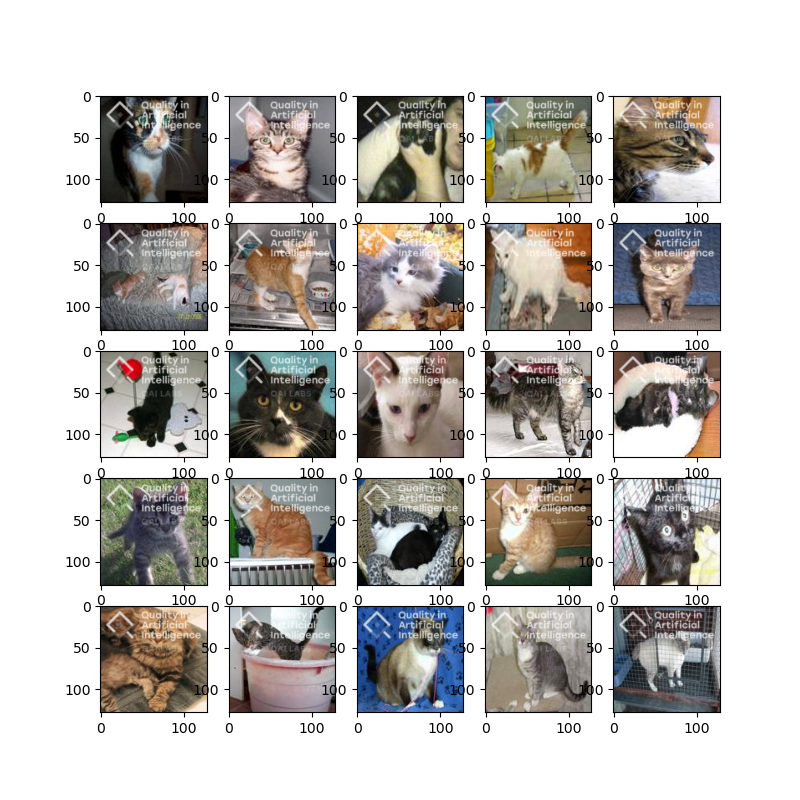

In [13]:
rows = 5
cols = 5

fig, axs = plt.subplots(rows,cols, figsize=(8,8))
plt_ind = 0 
for i in range(rows):
    for j in range(cols):
        watermark_image=watermark_dataset[plt_ind][0]    
        axs[i,j].imshow(watermark_image.transpose(1,2,0))
        plt_ind += 1 
plt.show()

In [14]:
n = 19
model_ind = 0
split = 0
model_conf=load_model(f'./models/cnn_confounder_{split}_{model_ind}.pt').to(device).eval()
model_sup=load_model(f'./models/cnn_suppressor_{split}_{model_ind}.pt').to(device).eval()
model_no=load_model(f'./models/cnn_no_watermark_{split}_{model_ind}.pt').to(device).eval()

watermark_image=watermark_dataset[n][0]    
data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)

no_watermark_image=no_watermark_dataset[n][0]
data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)

#target (same for both images)
target=watermark_dataset[n][1]

atts={'watermark_conf':plot_atts(data_watermark,model_conf,target),
      'watermark_sup':plot_atts(data_watermark,model_sup,target),
      'watermark_no':plot_atts(data_watermark,model_no,target),
      'no_watermark_conf':plot_atts(data_no_watermark,model_conf,target),
      'no_watermark_sup':plot_atts(data_no_watermark,model_sup,target),
      'no_watermark_no':plot_atts(data_no_watermark,model_no,target)}

C:\Users\clark01\AppData\Local\miniforge-pypy3\envs\debugging\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\clark01\AppData\Local\miniforge-pypy3\envs\debugging\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
C:\Users\clark01\AppData\Local\miniforge-pypy3\envs\debugging\Lib\site-packages\captum\attr\_core\lime.py:1095: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  warnings.warn(


KeyboardInterrupt: 

In [44]:
# Scale matrix to sum to 1
def sum_to_1(mat):
    # return mat / np.sum(mat)
    # return mat / np.linalg.norm(mat)
    
    scale = 1 / np.max(np.abs(mat))
    return mat * scale

atts['diff_conf'] = {}
atts['diff_sup'] = {}
atts['diff_no'] = {}

for key, value in atts['watermark_conf'][0].items():
    print(key)

    atts['diff_conf'][key] =  abs(sum_to_1(atts['watermark_conf'][0][key]) - sum_to_1(atts['no_watermark_conf'][0][key]))
    atts['diff_sup'][key] = abs(sum_to_1(atts['watermark_sup'][0][key]) - sum_to_1(atts['no_watermark_sup'][0][key]))
    atts['diff_no'][key] = abs(sum_to_1(atts['watermark_no'][0][key]) - sum_to_1(atts['no_watermark_no'][0][key]))

deconv
saliency
gradients
shap
backprop
ix
lrp
lime
lrp-ab


In [32]:
sum_to_1(atts['watermark_conf'][0][key].max())

1.0

In [34]:
sum_to_1(atts['no_watermark_conf'][0][key].max())

1.0

In [78]:
atts['diff_conf'][key].max()

0.9960987536046498

In [79]:
atts['diff_conf'][key].min()

0.0

In [54]:
arr = atts['diff_conf'][key].flatten()
top_2_idx = np.argsort(arr)[-int(arr.shape[0]/2):]
top_2_values = [arr[i] for i in top_2_idx]

In [69]:
top_frac_bounds(arr, thresh=0.1)

(0.00013537784440756202, 0.006400578392244701)

In [45]:
def rgb2gray(rgb):
    rgb = rgb.transpose(1,2,0)
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def gray2rgb(gray):

    rgb = np.stack((gray,)*3, axis=-1)

    return rgb


def top_frac_bounds(arr, thresh=0.5):
    arr = atts['diff_conf'][key].flatten()
    top_frac_idx = np.argsort(arr)[-int(arr.shape[0]*thresh):]
    top_frac_values = [arr[i] for i in top_frac_idx]
    return min(top_frac_values), max(top_frac_values)

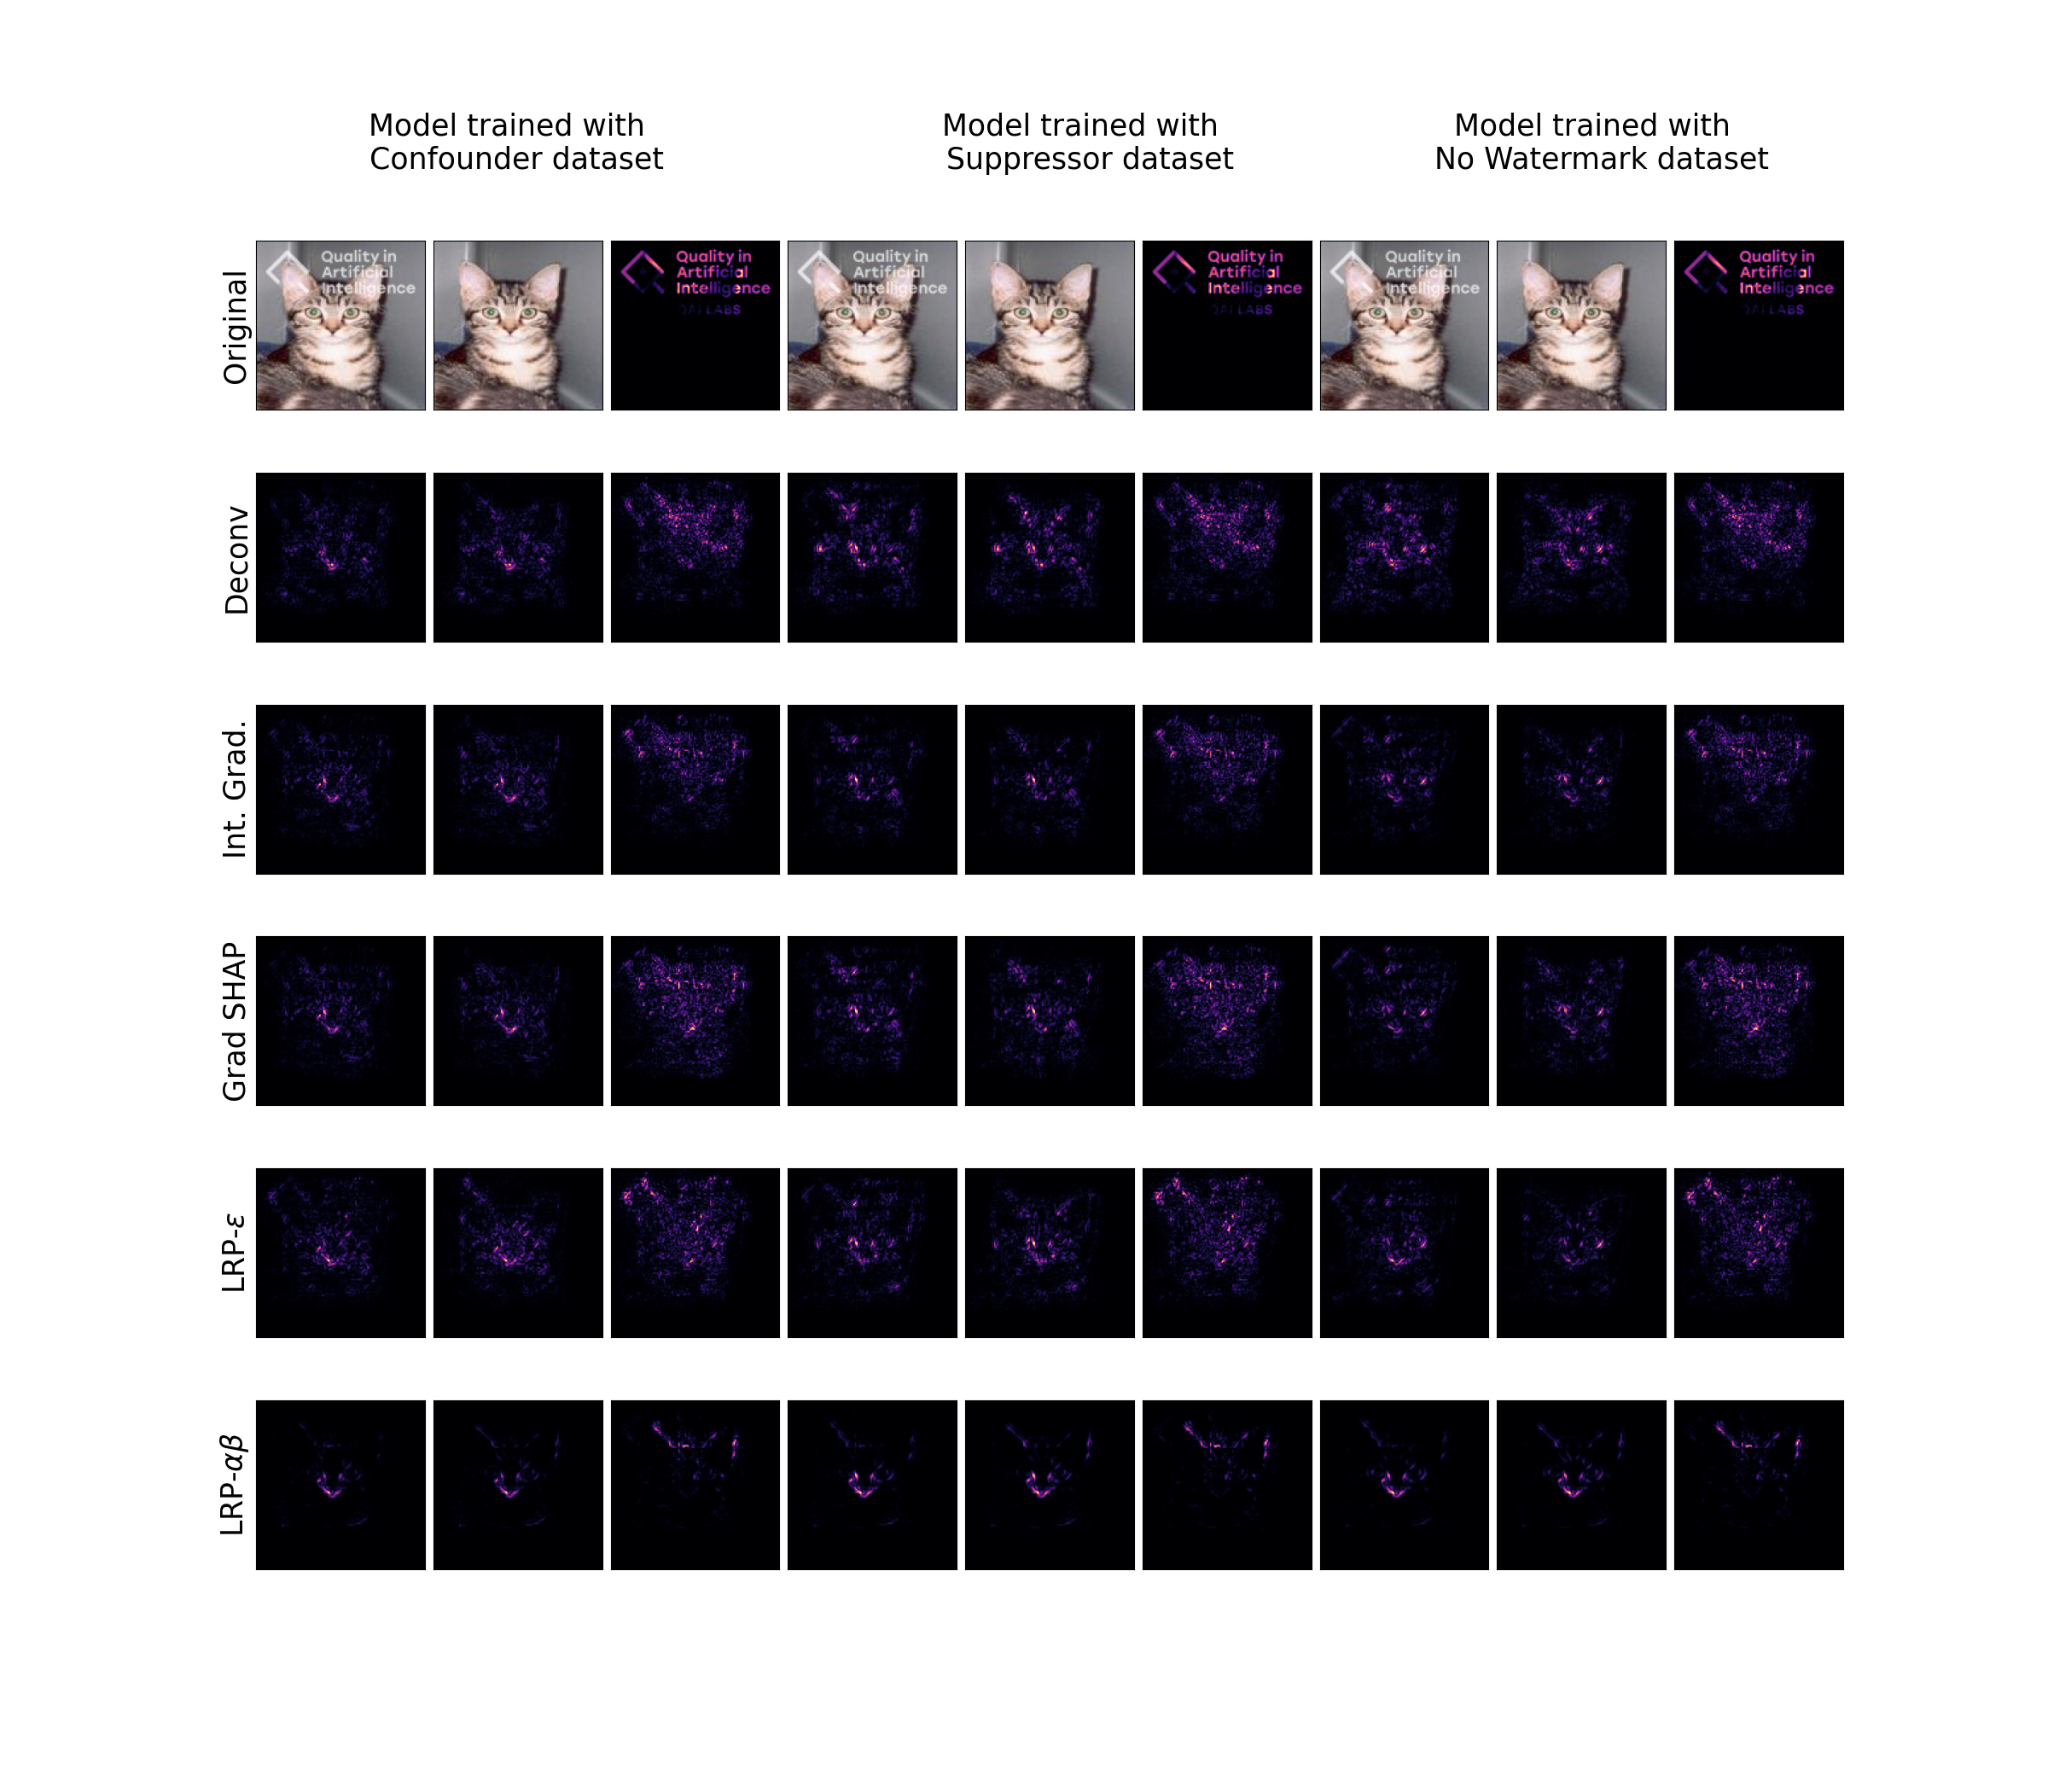

In [46]:
%matplotlib ipympl

def plots(n,atts, device, model_ind=0):
    #images
    watermark_image=watermark_dataset[n][0]    
    data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    no_watermark_image=no_watermark_dataset[n][0]
    data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    #target (same for both images)
    target=watermark_dataset[n][1]
    
    #models
#     model_conf = model_confounder.to(device)
#     model_sup = model_supressor.to(device)
#     model_no = model_no_water.to(device)

    model_conf=load_model(f'./models/cnn_conf_{model_ind}.pt').to(device)
    model_sup=load_model(f'./models/cnn_sup_{model_ind}.pt').to(device)
    model_no=load_model(f'./models/cnn_no_{model_ind}.pt').to(device)
    
    #plots 
    fig, axs = plt.subplots(6, 9,figsize=(24, 21))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    font_size=25
    plt.rcParams['font.size'] = font_size
    plt.rc('axes', titlesize=font_size) #title
    
    # atts={'watermark_conf':plot_atts(data_watermark,model_conf,target),
    #       'watermark_sup':plot_atts(data_watermark,model_sup,target),
    #       'watermark_no':plot_atts(data_watermark,model_no,target),
    #       'no_watermark_conf':plot_atts(data_no_watermark,model_conf,target),
    #       'no_watermark_sup':plot_atts(data_no_watermark,model_sup,target),
    #       'no_watermark_no':plot_atts(data_no_watermark,model_no,target)}
    
    
    original_imgs=[watermark_image,no_watermark_image, abs(rgb2gray(watermark_image) - rgb2gray(no_watermark_image)),
                   watermark_image,no_watermark_image, abs(rgb2gray(watermark_image) - rgb2gray(no_watermark_image)),
                   watermark_image,no_watermark_image,  abs(rgb2gray(watermark_image) - rgb2gray(no_watermark_image))]
    
    images=[atts['watermark_conf'][0],atts['no_watermark_conf'][0], atts['diff_conf'],
            atts['watermark_sup'][0],atts['no_watermark_sup'][0], atts['diff_conf'],
            atts['watermark_no'][0],atts['no_watermark_no'][0], atts['diff_conf'] ]
    
    probs=[atts['watermark_conf'][1],atts['no_watermark_conf'][1],
            atts['watermark_sup'][1],atts['no_watermark_sup'][1],
            atts['watermark_no'][1],atts['no_watermark_no'][1]]
    
    labels=['Original', 'Deconv','Int. Grad.','Grad SHAP',r'LRP-$\epsilon$', r'LRP-$\alpha \beta$']
    # cmap='cubehelix'
    # cmap='hot'
    # cmap='inferno'
    # cmap='CMRmap'
    cmap = 'magma'
    
    for i in range(9): #images watermark/no watermark
        if i == 2 or i == 5 or i == 8:
            axs[0,i].imshow(original_imgs[i], cmap=cmap)
        else:
            axs[0,i].imshow(original_imgs[i].transpose(1,2,0))
        axs[1,i].imshow(images[i]['deconv'],cmap=cmap)
        axs[2,i].imshow(images[i]['gradients'],cmap=cmap)
        axs[3,i].imshow(images[i]['shap'],cmap=cmap)
        axs[4,i].imshow(images[i]['lrp'],cmap=cmap)
        axs[5,i].imshow(images[i]['lrp-ab'],cmap=cmap)
        for j in range(6): #original image + XAI methods
            axs[j,i].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
#             axs[6,i].imshow(images[i]['lime'],cmap=cmap)
#             axs[0,i].title.set_text(f'p={round(float(probs[i][target].cpu().detach().numpy()),3)}')
            
            if i==0:
                axs[j,0].set_ylabel(labels[j]) 
    
    #titles model type
    plt.figtext(0.25,0.92,"Model trained with \n Confounder dataset", va="center", ha="center", size=font_size)
    plt.figtext(0.53,0.92,"Model trained with \n Suppressor dataset", va="center", ha="center", size=font_size)
    plt.figtext(0.78,0.92,"Model trained with \n No Watermark dataset", va="center", ha="center", size=font_size)
    plt.savefig(f'qualitative_{n}.png', bbox_inches='tight', dpi=300)
    
torch.manual_seed(SEED)  

#dog n=1000
#cat n=2

# max diff = 628
# for ind in top_inds:
#     plots(ind,device,0)

for ind in [1]:

    # n = ind
    
    # watermark_image=watermark_dataset[n][0]    
    # data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    # no_watermark_image=no_watermark_dataset[n][0]
    # data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    # #target (same for both images)
    # target=watermark_dataset[n][1]
    
    # atts={'watermark_conf':plot_atts(data_watermark,model_conf,target),
    #       'watermark_sup':plot_atts(data_watermark,model_sup,target),
    #       'watermark_no':plot_atts(data_watermark,model_no,target),
    #       'no_watermark_conf':plot_atts(data_no_watermark,model_conf,target),
    #       'no_watermark_sup':plot_atts(data_no_watermark,model_sup,target),
    #       'no_watermark_no':plot_atts(data_no_watermark,model_no,target)}
    
    plots(ind,atts,device,0)

In [97]:
n = 2
no_watermark_image=no_watermark_dataset[n][0]
data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)

model_no=load_model(f'./models/cnn_no_0.pt').to(device)
att_nw = plot_atts(data_no_watermark,model_no,target)


C:\Users\clark01\AppData\Local\miniforge-pypy3\envs\debugging\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\clark01\AppData\Local\miniforge-pypy3\envs\debugging\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
C:\Users\clark01\AppData\Local\miniforge-pypy3\envs\debugging\Lib\site-packages\captum\attr\_core\lime.py:1095: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  warnings.warn(


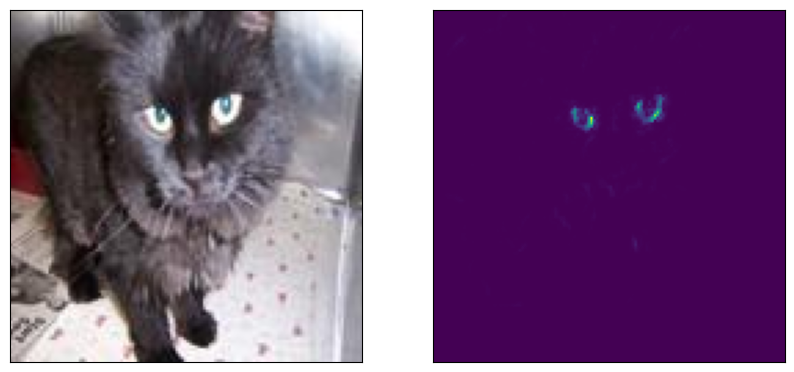

In [104]:
%matplotlib inline
fig, axs = plt.subplots(1,2, figsize=(10,10))

axs[0].imshow(data_no_watermark.squeeze().detach().numpy().transpose(1,2,0))
axs[1].imshow(att_nw[0]['lrp-ab'])

for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [87]:
%matplotlib widget

def plots(n,atts, device, model_ind=0):
    #images
    watermark_image=watermark_dataset[n][0]    
    data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    no_watermark_image=no_watermark_dataset[n][0]
    data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    #target (same for both images)
    target=watermark_dataset[n][1]
    
    #models
#     model_conf = model_confounder.to(device)
#     model_sup = model_supressor.to(device)
#     model_no = model_no_water.to(device)

    model_conf=load_model(f'./models/cnn_conf_{model_ind}.pt').to(device)
    model_sup=load_model(f'./models/cnn_sup_{model_ind}.pt').to(device)
    model_no=load_model(f'./models/cnn_no_{model_ind}.pt').to(device)
    
    #plots 
    fig, axs = plt.subplots(4, 9,figsize=(30, 15))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    font_size=25
    plt.rcParams['font.size'] = font_size
    plt.rc('axes', titlesize=font_size) #title
    
    # atts={'watermark_conf':plot_atts(data_watermark,model_conf,target),
    #       'watermark_sup':plot_atts(data_watermark,model_sup,target),
    #       'watermark_no':plot_atts(data_watermark,model_no,target),
    #       'no_watermark_conf':plot_atts(data_no_watermark,model_conf,target),
    #       'no_watermark_sup':plot_atts(data_no_watermark,model_sup,target),
    #       'no_watermark_no':plot_atts(data_no_watermark,model_no,target)}
    
    
    original_imgs=[watermark_image,no_watermark_image, abs(rgb2gray(watermark_image) - rgb2gray(no_watermark_image)),
                   watermark_image,no_watermark_image, abs(rgb2gray(watermark_image) - rgb2gray(no_watermark_image)),
                   watermark_image,no_watermark_image,  abs(rgb2gray(watermark_image) - rgb2gray(no_watermark_image))]
    
    images=[atts['watermark_conf'][0],atts['no_watermark_conf'][0], atts['diff_conf'],
            atts['watermark_sup'][0],atts['no_watermark_sup'][0], atts['diff_conf'],
            atts['watermark_no'][0],atts['no_watermark_no'][0], atts['diff_conf'] ]
    
    probs=[atts['watermark_conf'][1],atts['no_watermark_conf'][1],
            atts['watermark_sup'][1],atts['no_watermark_sup'][1],
            atts['watermark_no'][1],atts['no_watermark_no'][1]]
    
    labels=['Original','Int. Grad.','Grad SHAP',r'LRP']
    # cmap='cubehelix'
    # cmap='hot'
    # cmap='inferno'
    # cmap='CMRmap'
    cmap = 'magma'

    plot_methods = ['gradients', 'shap', 'lrp']
    
    for i in range(9): #images watermark/no watermark
        if i == 2 or i == 5 or i == 8:
            axs[0,i].imshow(original_imgs[i], cmap=cmap)

            for ind, method in enumerate(plot_methods):
                vmin, vmax = top_frac_bounds(images[i][method], thresh=1.0)
                axs[ind+1,i].imshow(images[i][method],cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            axs[0,i].imshow(original_imgs[i].transpose(1,2,0))
            for ind, method in enumerate(plot_methods):
                axs[ind+1,i].imshow(images[i][method],cmap=cmap)
                
        for j in range(4): #original image + XAI methods
            axs[j,i].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
#             axs[6,i].imshow(images[i]['lime'],cmap=cmap)
#             axs[0,i].title.set_text(f'p={round(float(probs[i][target].cpu().detach().numpy()),3)}')
            
            if i==0:
                axs[j,0].set_ylabel(labels[j]) 
    
    #titles model type
    plt.figtext(0.25,0.89,"Confounder Model", va="center", ha="center", size=font_size)
    plt.figtext(0.53,0.89,"Suppressor Model", va="center", ha="center", size=font_size)
    plt.figtext(0.78,0.89,"No Watermark Model", va="center", ha="center", size=font_size)
    plt.savefig(f'qualitative_{n}.png', bbox_inches='tight', dpi=300)
    
torch.manual_seed(SEED)  

#dog n=1000
#cat n=2

# max diff = 628
# for ind in top_inds:
#     plots(ind,device,0)

for ind in [0]:

    # n = ind
    
    # watermark_image=watermark_dataset[n][0]    
    # data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    # no_watermark_image=no_watermark_dataset[n][0]
    # data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    # #target (same for both images)
    # target=watermark_dataset[n][1]
    
    # atts={'watermark_conf':plot_atts(data_watermark,model_conf,target),
    #       'watermark_sup':plot_atts(data_watermark,model_sup,target),
    #       'watermark_no':plot_atts(data_watermark,model_no,target),
    #       'no_watermark_conf':plot_atts(data_no_watermark,model_conf,target),
    #       'no_watermark_sup':plot_atts(data_no_watermark,model_sup,target),
    #       'no_watermark_no':plot_atts(data_no_watermark,model_no,target)}
    
    plots(ind,atts,device,1)

<IPython.core.display.Javascript object>

# Energy

In [4]:
import os
# import nibabel as nib

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import time
import pickle
import random

from scipy import ndimage

# from skimage.filters import threshold_otsu
# from skimage.measure import label, regionprops
# from skimage import transform
# from skimage.transform import resize
# import skimage.exposure as skie

import ot

import torch
from torch import manual_seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
# from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

import gc 
from PIL import Image 

torch.cuda.is_available()

torch.set_num_threads(3)



from captum.attr import IntegratedGradients, Saliency, DeepLift, DeepLiftShap, GradientShap  
from captum.attr import GuidedBackprop, Deconvolution, LRP, InputXGradient, Lime

# from zennit.composites import EpsilonPlusFlat
# from zennit.composites import EpsilonAlpha2Beta1



def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

import os
folder=os.getcwd()
watermark_path=folder+'/watermark banner.jpg'
watermark = Image.open(watermark_path)
w=int(watermark_dataset[0][0].shape[1])
h=int(watermark.size[1]*w/watermark.size[0])
watermark = watermark.resize((w,h))
watermark=np.array(watermark)
rgb=rescale_values(watermark,1,0)
r, g, blue = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
gray = 1-(0.2989 * r + 0.5870 * g + 0.1140 * blue)
white=np.ones((w,w))
white[0:gray.shape[0],0:gray.shape[1]]=gray

bin_water=1.0*(white<1)

def energy(att):
    image_size=att.shape[0]*att.shape[1]
    watermark_size=np.sum(bin_water)
    
    watermark_att=att*bin_water
    watermark_energy=np.sum(watermark_att)
    
    image_energy=np.sum(att)

    energy=(watermark_energy/watermark_size)/(image_energy/image_size)
    
    return energy
    

NameError: name 'watermark_dataset' is not defined

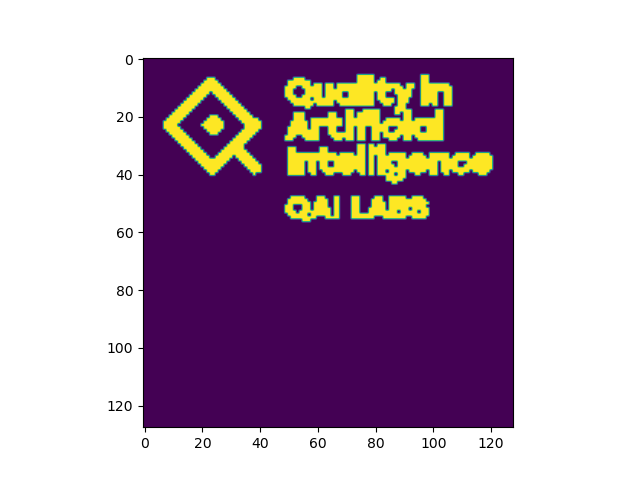

In [11]:
import os
folder=os.getcwd()
watermark_path=folder+'/watermark banner.jpg'
watermark = Image.open(watermark_path)
w=int(watermark_dataset[0][0].shape[1])
h=int(watermark.size[1]*w/watermark.size[0])
watermark = watermark.resize((w,h))
watermark=np.array(watermark)
rgb=rescale_values(watermark,1,0)
r, g, blue = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
gray = 1-(0.2989 * r + 0.5870 * g + 0.1140 * blue)
white=np.ones((w,w))
white[0:gray.shape[0],0:gray.shape[1]]=gray

bin_water=1.0*(white<1)
plt.imshow(bin_water)
# plt.show()

In [50]:
n=1000
watermark_example=torch.tensor(watermark_dataset[n][0]).unsqueeze(0).to(device,dtype=torch.float)
a=plot_atts(watermark_example,model_confounder,target)
plt.imshow(a[0]['deconv'])

C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\_utils\gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\attr\_core\lime.py:1102: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  "Attempting to construct interpretable model with > 10000 features."


C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\_utils\gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\attr\_core\lime.py:1102: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  "Attempting to construct interpretable model with > 10000 features."


<IPython.core.display.Javascript object>


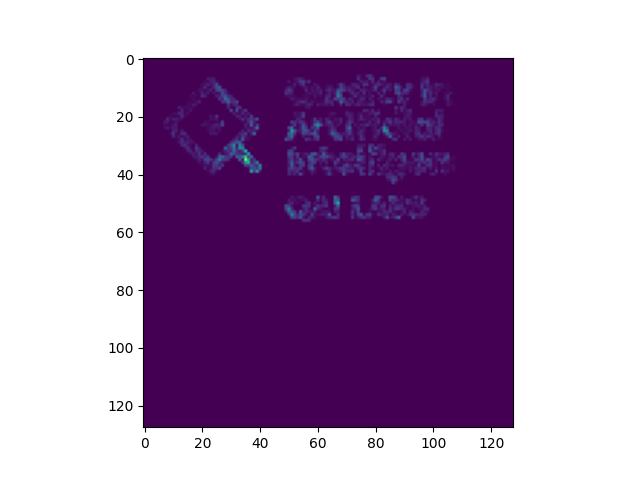

In [51]:
n=20
watermark_image=watermark_dataset[n][0] 
target=watermark_dataset[n][1] 
data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
a,_=plot_atts(data_watermark,model_confounder,target)
plt.imshow(a['deconv'],vmax=np.max(a['deconv']),vmin=np.min(a['deconv']))

plt.figure()
plt.imshow(a['deconv']*bin_water,vmax=np.max(a['deconv']),vmin=np.min(a['deconv']))

In [14]:
def energy(att):
    image_size=att.shape[0]*att.shape[1]
    watermark_size=np.sum(bin_water)
    
    watermark_att=att*bin_water
    watermark_energy=np.sum(watermark_att)
    
    image_energy=np.sum(att)

    energy=(watermark_energy/watermark_size)/(image_energy/image_size)
    
    return energy
    
    
    

In [14]:
print('watermark size:', np.sum(bin_water))
print('image size:', bin_water.shape[0]*bin_water.shape[1])

print('watermark_energy', np.sum(bin_water*bin_water))

watermark size: 2085.0
image size: 16384
watermark_energy 2085.0


In [20]:
# energy_water_conf={'deconv':[],'gradients':[],'shap':[],'lrp':[]}
# energy_water_sup={'deconv':[],'gradients':[],'shap':[],'lrp':[]}
# energy_water_no={'deconv':[],'gradients':[],'shap':[],'lrp':[]}

# model_conf=load_trained('./artifacts/cnn_conf.pt').to(device)
# model_sup=load_trained('./artifacts/cnn_sup.pt').to(device)
# model_no=load_trained('./artifacts/cnn_no.pt').to(device)

# folder=os.getcwd()+'/images'
# print(folder)
# t0=time.time()
# for i,w_image in enumerate(watermark_dataset):
#     image=w_image[0]
#     target=w_image[1]
    
#     example=torch.tensor(image).unsqueeze(0).to(device,dtype=torch.float)
    
#     a_conf_w,_=plot_atts(example,model_conf,target)
#     a_sup_w,_=plot_atts(example,model_sup,target)
#     a_no_w,_=plot_atts(example,model_no,target)
    
#     for method in list(energy_water_conf.keys()):
#         energy_water_conf[method].append(energy(a_conf_w[method]))
#         energy_water_sup[method].append(energy(a_sup_w[method]))
#         energy_water_no[method].append(energy(a_no_w[method]))

#     if i%100==0:
#         print(f'{i} out of {len(watermark_dataset)}')
#         print(time.time()-t0)
#         t0=time.time()
                
# energy_no_water_conf={'deconv':[],'gradients':[],'shap':[],'lrp':[]}
# energy_no_water_sup={'deconv':[],'gradients':[],'shap':[],'lrp':[]}
# energy_no_water_no={'deconv':[],'gradients':[],'shap':[],'lrp':[]}

# t0=time.time()
# for i,w_image in enumerate(no_watermark_dataset):
#     image=w_image[0]
#     target=w_image[1]
    
#     example=torch.tensor(image).unsqueeze(0).to(device,dtype=torch.float)
    
#     a_conf_nw,_=plot_atts(example,model_confounder,target)
#     a_sup_nw,_=plot_atts(example,model_supressor,target)
#     a_no_nw,_=plot_atts(watermark_example,model_no_water,target)
    
#     for method in list(energy_water_conf.keys()):
#         energy_no_water_conf[method].append(energy(a_conf_nw[method]))
#         energy_no_water_sup[method].append(energy(a_sup_nw[method]))
#         energy_no_water_no[method].append(energy(a_no_nw[method]))
    
#     if i%100==0:
#         print(f'{i} out of {len(no_watermark_dataset)}')
#         print(time.time()-t0)
#         t0=time.time()


C:\Users\clark01\Documents\braindata\debugging_xai/images


NameError: name 'plot_atts' is not defined

In [119]:
with open('energy_water_conf.pickle', 'wb') as f:
    pickle.dump(energy_water_conf, f) 

In [58]:
# import pickle
    
# with open('energy_water_conf.pickle', 'wb') as f:
#     pickle.dump(energy_water_conf, f)    
# with open('energy_water_sup.pickle', 'wb') as f:
#     pickle.dump(energy_water_sup, f)    
# with open('energy_water_no.pickle', 'wb') as f:
#     pickle.dump(energy_water_no, f)    
    
# with open('energy_no_water_conf.pickle', 'wb') as f:
#     pickle.dump(energy_no_water_conf, f)    
# with open('energy_no_water_sup.pickle', 'wb') as f:
#     pickle.dump(energy_no_water_sup, f)    
# with open('energy_no_water_no.pickle', 'wb') as f:
#     pickle.dump(energy_no_water_no, f)



In [5]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
model_ind = 0
file = open(f'energy_water_conf_comb_pred_{model_ind}.pickle', 'rb')
energy_water_conf = pickle.load(file)

file = open(f'energy_water_sup_comb_pred_{model_ind}.pickle', 'rb')
energy_water_sup = pickle.load(file)

file = open(f'energy_water_no_comb_pred_{model_ind}.pickle', 'rb')
energy_water_no = pickle.load(file)

file = open(f'energy_no_water_conf_comb_pred_{model_ind}.pickle', 'rb')
energy_no_water_conf = pickle.load(file)

file = open(f'energy_no_water_sup_comb_pred_{model_ind}.pickle', 'rb')
energy_no_water_sup = pickle.load(file)

file = open(f'energy_no_water_no_comb_pred_{model_ind}.pickle', 'rb')
energy_no_water_no = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'energy_water_conf_comb_pred_0.pickle'

In [13]:
energy_water_conf.keys()

dict_keys(['deconv', 'int_grads', 'shap', 'lrp', 'lrp_ab'])

In [14]:
energy_no_water_conf['lrp']

[1.0810921554473814,
 1.586808100250706,
 1.7587400626938774,
 1.303354646039489,
 1.391058540833445,
 1.5584711900513613,
 1.9471212087512282,
 1.6044788068986529,
 1.7830902970992342,
 1.4489419447625311,
 1.9138075773755638,
 2.602929581312383,
 1.7230839494794747,
 1.5532211633282782,
 0.8804129174471507,
 1.6538990328219936,
 1.4037607034818715,
 1.9620314579233178,
 1.7235518626376383,
 1.6144306127426231,
 1.83549898993356,
 1.9652120678633032,
 1.6017664495644555,
 1.7663000384926142,
 1.5193648041463275,
 1.7230181041690762,
 2.0275575306727727,
 2.1637358813031575,
 2.172684362578171,
 1.6627674255975717,
 1.9774295539699525,
 1.4472623627666046,
 1.5579511610555141,
 1.563983755234925,
 1.755175507363679,
 1.9019337029415684,
 0.8012035487050388,
 1.5929640098526991,
 2.3787628977046635,
 1.886828868370843,
 1.8641089737123886,
 1.481431408511049,
 1.7847387194427184,
 1.746327468017712,
 1.6896531034357065,
 1.8727399246688294,
 2.1099144400679957,
 1.8756150039191635,
 1.8

In [20]:
energy_water_conf.keys()

dict_keys(['deconv', 'int_grads', 'shap', 'lrp', 'lime'])

In [21]:
l3 = [l1-l2 for l1, l2 in zip(energy_water_no['lrp'], energy_no_water_no['lrp'])]
l3_sorted = l3.copy()
l3_sorted.sort(reverse=True)

In [26]:
l3_sorted[:10]

[0.805725140438436,
 0.7396122597984132,
 0.7047845682412077,
 0.7029563428092359,
 0.6838042592604917,
 0.6733812216999159,
 0.6542421826789573,
 0.644020545466118,
 0.6435588701880619,
 0.6266536843916267]

In [27]:
top_inds = []
for ind in l3_sorted[:10]:
    top_inds.append(l3.index(ind))

In [28]:
top_inds

[2659, 773, 165, 859, 1935, 926, 292, 1088, 1032, 1507]

In [25]:
l3.index(l3_sorted[1000])

22

In [49]:
l3_sorted[1000]

0.19270969918731007

In [46]:
len(l3)

3000

In [11]:
lst = []
print(len(energy_water_conf['deconv']))
for i in range(5):
    lst.extend(energy_water_conf['deconv'])
print(len(lst))

3000
15000


In [3]:
# train_energy=[]
# methods = ['deconv', 'int_grads', 'shap', 'lrp', 'lrp_ab'] # lime just nan values
# # methods = ['deconv', 'int_grads', 'shap', 'lrp']
# n_test = 3000

# for method in methods:
#     comb_water_conf = []
#     comb_water_sup = []
#     comb_water_no = []
    
#     comb_no_water_conf = []
#     comb_no_water_sup = []
#     comb_no_water_no = []

#     if method == 'lrp_ab':
#         file_suffix = 'lrp_'
#     else:
#         file_suffix=''
    
#     for split in range(10):
#         for model_ind in range(10):
#             file = open(f'./energies/energy_water_conf_pred_{file_suffix}{split}_{model_ind}.pickle', 'rb')
#             energy_water_conf = pickle.load(file)
    
#             file = open(f'./energies/energy_water_sup_pred_{file_suffix}{split}_{model_ind}.pickle', 'rb')
#             energy_water_sup = pickle.load(file)
    
#             file = open(f'./energies/energy_water_no_pred_{file_suffix}{split}_{model_ind}.pickle', 'rb')
#             energy_water_no = pickle.load(file)
    
#             file = open(f'./energies/energy_no_water_conf_pred_{file_suffix}{split}_{model_ind}.pickle', 'rb')
#             energy_no_water_conf = pickle.load(file)
    
#             file = open(f'./energies/energy_no_water_sup_pred_{file_suffix}{split}_{model_ind}.pickle', 'rb')
#             energy_no_water_sup = pickle.load(file)
    
#             file = open(f'./energies/energy_no_water_no_pred_{file_suffix}{split}_{model_ind}.pickle', 'rb')
#             energy_no_water_no = pickle.load(file)
            
#             comb_water_conf.extend(energy_water_conf[method][:n_test])
#             comb_water_sup.extend(energy_water_sup[method][:n_test])
#             comb_water_no.extend(energy_water_no[method][:n_test])
    
#             comb_no_water_conf.extend(energy_no_water_conf[method][:n_test])
#             comb_no_water_sup.extend(energy_no_water_sup[method][:n_test])
#             comb_no_water_no.extend(energy_no_water_no[method][:n_test])
            
          
            
            
#     train_energy.append([[comb_no_water_conf, comb_water_conf],
#                 [comb_no_water_sup, comb_water_sup],
#                 [comb_no_water_no, comb_water_no]])

# #     train_energy.append([[comb_water_conf, comb_no_water_conf],
# #                 [comb_water_sup, comb_no_water_sup],
# #                 [comb_water_no, comb_no_water_no]])
    
# np.array(train_energy).shape

(5, 3, 2, 180000)

In [7]:
train_energy=[]
methods = ['deconv', 'int_grads', 'shap', 'lrp', 'lrp_ab', 'laplace', 'sobel', 'x'] # lime just nan values
# methods = ['deconv', 'int_grads', 'shap', 'lrp']
n_test = 3000

for method in methods:
    comb_water_conf = []
    comb_water_sup = []
    comb_water_no = []
    
    comb_no_water_conf = []
    comb_no_water_sup = []
    comb_no_water_no = []

    # if method == 'lrp_ab':
    #     file_suffix = ''
    # else:
    
    file_suffix=''
    
    for split in range(5):
        # for model_ind in range(10):
        
        file = open(f'./energies/energy_water_conf_pred_{file_suffix}{split}.pickle', 'rb')
        energy_water_conf = pickle.load(file)

        file = open(f'./energies/energy_water_sup_pred_{file_suffix}{split}.pickle', 'rb')
        energy_water_sup = pickle.load(file)

        file = open(f'./energies/energy_water_no_pred_{file_suffix}{split}.pickle', 'rb')
        energy_water_no = pickle.load(file)

        file = open(f'./energies/energy_no_water_conf_pred_{file_suffix}{split}.pickle', 'rb')
        energy_no_water_conf = pickle.load(file)

        file = open(f'./energies/energy_no_water_sup_pred_{file_suffix}{split}.pickle', 'rb')
        energy_no_water_sup = pickle.load(file)

        file = open(f'./energies/energy_no_water_no_pred_{file_suffix}{split}.pickle', 'rb')
        energy_no_water_no = pickle.load(file)

        # print(energy_water_no.keys())
        
        comb_water_conf.extend(energy_water_conf[method][:n_test])
        comb_water_sup.extend(energy_water_sup[method][:n_test])

        if method == 'laplace' or method == 'sobel' or method == 'x':
            comb_water_no.extend(energy_water_sup[method][:n_test])
            comb_no_water_conf.extend(energy_no_water_sup[method][:n_test])
        else:
            comb_water_no.extend(energy_water_no[method][:n_test])
            comb_no_water_conf.extend(energy_no_water_conf[method][:n_test])
            

        # comb_no_water_conf.extend(energy_no_water_conf[method][:n_test])
        comb_no_water_sup.extend(energy_no_water_sup[method][:n_test])
        comb_no_water_no.extend(energy_no_water_no[method][:n_test])
            
          
            
            
    train_energy.append([[comb_no_water_conf, comb_water_conf],
                [comb_no_water_sup, comb_water_sup],
                [comb_no_water_no, comb_water_no]])

#     train_energy.append([[comb_water_conf, comb_no_water_conf],
#                 [comb_water_sup, comb_no_water_sup],
#                 [comb_water_no, comb_no_water_no]])
    
np.array(train_energy).shape

(8, 3, 2, 15000)

In [8]:
energy_lapl_no = []
energy_lapl_wm = []

energy_sob_no = []
energy_sob_wm = []

energy_x_no = []
energy_x_wm = []

for split in range(10):
    with open(f'./energies/energy_baselines_{split}.pickle', 'rb') as f:
        [[lapl_no, lapl_wm], [sob_no, sob_wm], [x_no, x_wm]] = pickle.load(f)   

    energy_lapl_no.extend(lapl_no)
    energy_lapl_wm.extend(lapl_wm)
    
    energy_sob_no.extend(sob_no)
    energy_sob_wm.extend(sob_wm)
    
    energy_x_no.extend(x_no)
    energy_x_wm.extend(x_wm)


train_energy.append([ [energy_lapl_no, energy_lapl_wm], [energy_lapl_no, energy_lapl_wm], [energy_lapl_no, energy_lapl_wm] ])
train_energy.append([ [energy_sob_no, energy_sob_wm], [energy_sob_no, energy_sob_wm], [energy_sob_no, energy_sob_wm] ])
train_energy.append([ [energy_x_no, energy_x_wm], [energy_x_no, energy_x_wm], [energy_x_no, energy_x_wm] ])

In [29]:
# train_energy_zennit=[]
# # methods = ['lrp_ab'] # lime just nan values
# # methods = ['deconv', 'int_grads', 'shap', 'lrp']
# n_test = 3000

# for method in ['lrp']:
#     comb_water_conf = []
#     comb_water_sup = []
#     comb_water_no = []
    
#     comb_no_water_conf = []
#     comb_no_water_sup = []
#     comb_no_water_no = []
    
#     for model_ind in range(5):
#         file = open(f'zennit_energy_water_conf_{model_ind}.pickle', 'rb')
#         zennit_energy_water_conf = pickle.load(file)

#         file = open(f'zennit_energy_water_sup_{model_ind}.pickle', 'rb')
#         zennit_energy_water_sup = pickle.load(file)

#         file = open(f'zennit_energy_water_no_{model_ind}.pickle', 'rb')
#         zennit_energy_water_no = pickle.load(file)

#         file = open(f'zennit_energy_no_water_conf_{model_ind}.pickle', 'rb')
#         zennit_energy_no_water_conf = pickle.load(file)

#         file = open(f'zennit_energy_no_water_sup_{model_ind}.pickle', 'rb')
#         zennit_energy_no_water_sup = pickle.load(file)

#         file = open(f'zennit_energy_no_water_no_{model_ind}.pickle', 'rb')
#         zennit_energy_no_water_no = pickle.load(file)
        
#         comb_water_conf.extend(zennit_energy_water_conf[method][:n_test])
#         comb_water_sup.extend(zennit_energy_water_sup[method][:n_test])
#         comb_water_no.extend(zennit_energy_water_no[method][:n_test])

#         comb_no_water_conf.extend(zennit_energy_no_water_conf[method][:n_test])
#         comb_no_water_sup.extend(zennit_energy_no_water_sup[method][:n_test])
#         comb_no_water_no.extend(zennit_energy_no_water_no[method][:n_test])
        
        
        
        
#     train_energy_zennit.append([[comb_no_water_conf, comb_water_conf],
#                 [comb_no_water_sup, comb_water_sup],
#                 [comb_no_water_no, comb_water_no]])

# #     train_energy.append([[comb_water_conf, comb_no_water_conf],
# #                 [comb_water_sup, comb_no_water_sup],
# #                 [comb_water_no, comb_no_water_no]])
    
# np.array(train_energy_zennit).shape

In [10]:
train_energy.keys()

AttributeError: 'list' object has no attribute 'keys'

In [19]:
train= 2 # 0 conf 1 sup 2 no
method= 2 #0 deconv, 1 gradients, 2 shap, 3 lrp
variant= 1 #0 water, 1 no water


len(train_energy[method][train][variant])

180000

In [9]:
for n_method in range(5):
#     print(list(energy_no_water_conf.keys())[n_method])
    print(methods[n_method])
    print('====== dataset:watermark ======')
    
    print('model: confounder ', round(np.mean(np.array(train_energy[n_method][0][1])),3))
    print('model: supressor', round(np.mean(np.array(train_energy[n_method][1][1])),3))
    print('model: no watermark  ', round(np.mean(np.array(train_energy[n_method][2][1])),3))
    
    print('====== dataset:no watermark ======')
    
    print('model: confounder', round(np.mean(np.array(train_energy[n_method][0][0])),3))
    print('model: supressor ', round(np.mean(np.array(train_energy[n_method][1][0])),3))
    print('model: no watermark ', round(np.mean(np.array(train_energy[n_method][2][0])),3))
    print()

deconv
====== dataset:watermark ======
model: confounder  1.838
model: supressor 1.661
model: no watermark   2.014
====== dataset:no watermark ======
model: confounder 1.656
model: supressor  1.592
model: no watermark  1.702

int_grads
====== dataset:watermark ======
model: confounder  2.175
model: supressor 2.002
model: no watermark   2.55
====== dataset:no watermark ======
model: confounder 1.603
model: supressor  1.548
model: no watermark  1.713

shap
====== dataset:watermark ======
model: confounder  2.161
model: supressor 1.987
model: no watermark   2.506
====== dataset:no watermark ======
model: confounder 1.602
model: supressor  1.538
model: no watermark  1.695

lrp
====== dataset:watermark ======
model: confounder  2.249
model: supressor 2.054
model: no watermark   2.466
====== dataset:no watermark ======
model: confounder 1.604
model: supressor  1.573
model: no watermark  1.675

lrp_ab
====== dataset:watermark ======
model: confounder  2.599
model: supressor 2.379
model: no wa

In [31]:
# # for n_method in range(5):
# #     print(list(energy_no_water_conf.keys())[n_method])
# print('LRP alpha-beta from zennit')
# print('====== dataset:watermark ======')

# print('model: confounder ', round(np.mean(np.array(train_energy_zennit[0][0][1])),3))
# print('model: supressor', round(np.mean(np.array(train_energy_zennit[0][1][1])),3))
# print('model: no watermark  ', round(np.mean(np.array(train_energy_zennit[0][2][1])),3))

# print('====== dataset:no watermark ======')

# print('model: confounder', round(np.mean(np.array(train_energy_zennit[0][0][0])),3))
# print('model: supressor ', round(np.mean(np.array(train_energy_zennit[0][1][0])),3))
# print('model: no watermark ', round(np.mean(np.array(train_energy_zennit[0][2][0])),3))
# print()

LRP alpha-beta from zennit
====== dataset:watermark ======


IndexError: list index out of range

In [34]:
# train_energy.append(train_energy_zennit[0])

In [17]:
# watermark_dataset[0][0].shape

# wm_avg = np.zeros((3000,3,128,128))
# no_wm_avg = np.zeros((3000,3,128,128))

# for i in range(3000):
#     wm_avg[i] = watermark_dataset[i][0]
#     no_wm_avg[i] = no_watermark_dataset[i][0]
    
# wm_avg = np.mean(wm_avg, axis=0)
# no_wm_avg = np.mean(no_wm_avg, axis=0)

In [18]:
# from scipy.ndimage import sobel, laplace

# rgb_weights = [0.2989, 0.5870, 0.1140]

# lapl_wm = []
# sob_wm = []
# x_wm = []

# for x, label in watermark_dataset:
    
#     x_wm.append(energy(np.dot(x.copy().transpose(1,2,0)[...,:3], rgb_weights)))
    
#     sample = x.copy().transpose(1,2,0) - wm_avg.transpose(1,2,0)
#     img_r = sample[:,:,0]
#     img_g = sample[:,:,1]
#     img_b = sample[:,:,2]
    
#     lapl = np.abs(laplace(img_r)) + np.abs(laplace(img_g)) + np.abs(laplace(img_b))
#     sob = np.abs(sobel(img_r)) + np.abs(sobel(img_g)) + np.abs(sobel(img_b))
    
#     lapl_wm.append(energy(lapl))
#     sob_wm.append(energy(sob))
    
# lapl_no = []
# sob_no = []
# x_no = []

# for x, label in no_watermark_dataset:
    
#     x_no.append(energy(np.dot(x.copy().transpose(1,2,0)[...,:3], rgb_weights)))
    
#     sample = x.copy().transpose(1,2,0) - no_wm_avg.transpose(1,2,0)
#     img_r = sample[:,:,0]
#     img_g = sample[:,:,1]
#     img_b = sample[:,:,2]
    
#     lapl = np.abs(laplace(img_r)) + np.abs(laplace(img_g)) + np.abs(laplace(img_b))
#     sob = np.abs(sobel(img_r)) + np.abs(sobel(img_g)) + np.abs(sobel(img_b))
    
#     lapl_no.append(energy(lapl))
#     sob_no.append(energy(sob))
       
    

In [21]:
# with open('energy_laplace.pickle', 'wb') as f:
#     pickle.dump([lapl_no, lapl_wm], f) 
    
# with open('energy_sobel.pickle', 'wb') as f:
#     pickle.dump([sob_no, sob_wm], f) 
    
# with open('energy_x.pickle', 'wb') as f:
#     pickle.dump([x_no, x_wm], f) 

In [19]:
# train_energy.append([ [lapl_no, lapl_wm], [lapl_no, lapl_wm], [lapl_no, lapl_wm] ])
# train_energy.append([ [sob_no, sob_wm], [sob_no, sob_wm], [sob_no, sob_wm] ])
# train_energy.append([ [x_no, x_wm], [x_no, x_wm], [x_no, x_wm] ])

In [10]:
for n_method in range(7):
#     print(list(energy_no_water_conf.keys())[n_method])
#     print(methods[n_method])
    print('====== dataset:watermark ======')
    
    print('model: confounder ', round(np.mean(np.array(train_energy[n_method][0][1])),3))
    print('model: supressor', round(np.mean(np.array(train_energy[n_method][1][1])),3))
    print('model: no watermark  ', round(np.mean(np.array(train_energy[n_method][2][1])),3))
    
    print('====== dataset:no watermark ======')
    
    print('model: confounder', round(np.mean(np.array(train_energy[n_method][0][0])),3))
    print('model: supressor ', round(np.mean(np.array(train_energy[n_method][1][0])),3))
    print('model: no watermark ', round(np.mean(np.array(train_energy[n_method][2][0])),3))
    print()

====== dataset:watermark ======
model: confounder  1.838
model: supressor 1.661
model: no watermark   2.014
====== dataset:no watermark ======
model: confounder 1.656
model: supressor  1.592
model: no watermark  1.702

====== dataset:watermark ======
model: confounder  2.175
model: supressor 2.002
model: no watermark   2.55
====== dataset:no watermark ======
model: confounder 1.603
model: supressor  1.548
model: no watermark  1.713

====== dataset:watermark ======
model: confounder  2.161
model: supressor 1.987
model: no watermark   2.506
====== dataset:no watermark ======
model: confounder 1.602
model: supressor  1.538
model: no watermark  1.695

====== dataset:watermark ======
model: confounder  2.249
model: supressor 2.054
model: no watermark   2.466
====== dataset:no watermark ======
model: confounder 1.604
model: supressor  1.573
model: no watermark  1.675

====== dataset:watermark ======
model: confounder  2.599
model: supressor 2.379
model: no watermark   2.645
====== dataset:no

C:\Users\clark01\AppData\Local\Temp\1\ipykernel_13024\3894056745.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\clark01\AppData\Local\Temp\1\ipykernel_13024\3894056745.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color(sns.color_palette()[1])


Text(0.5, 0, 'Energy')

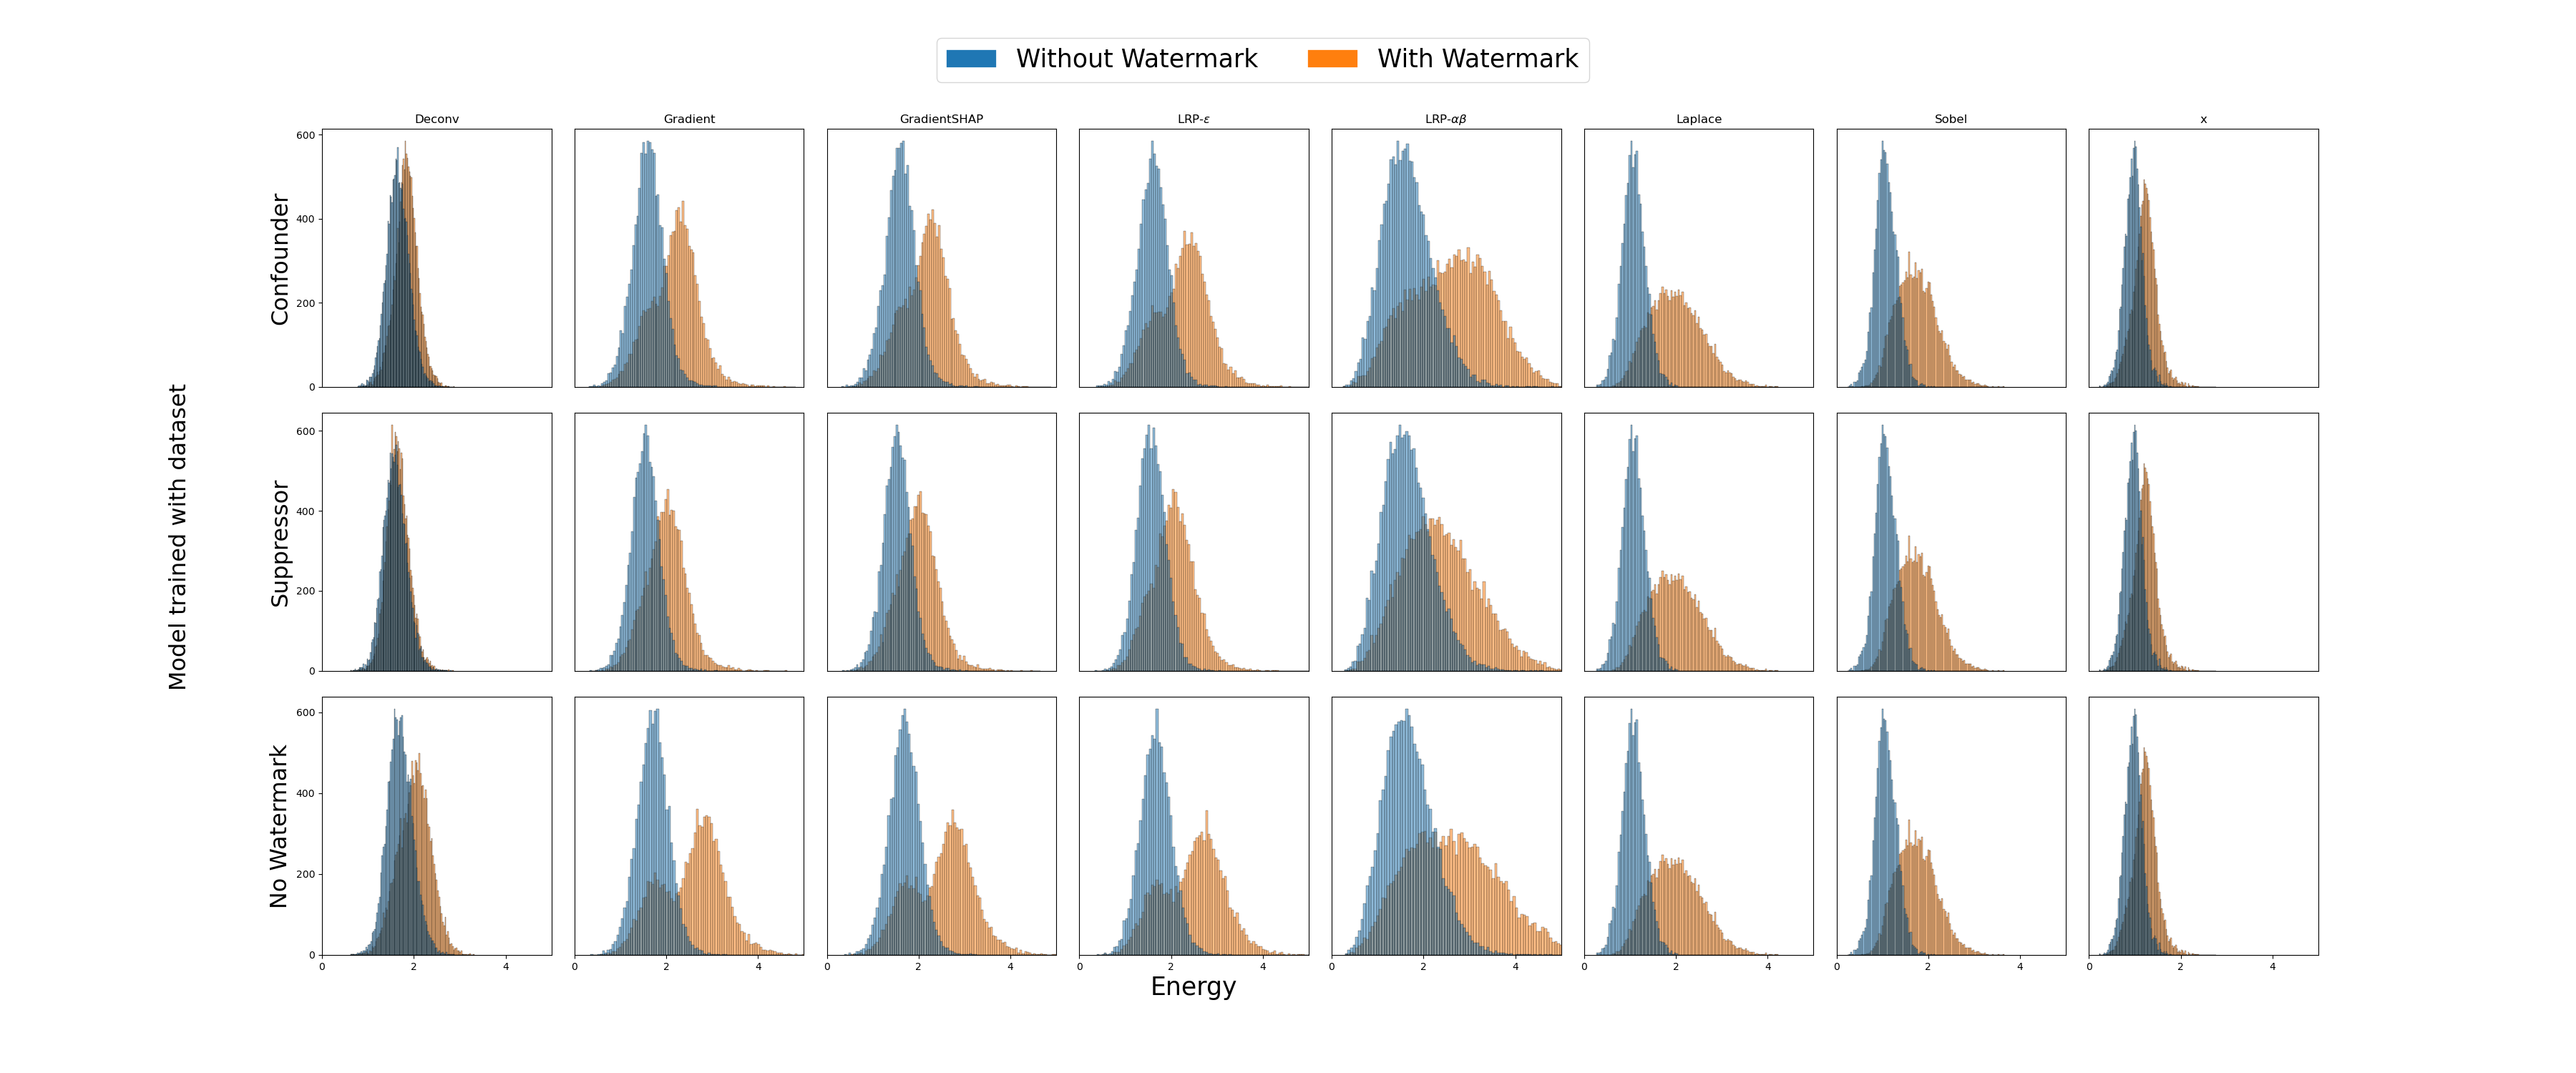

In [11]:
import seaborn as sns
fig, axs = plt.subplots(3, 8, figsize=(36, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
font_size=25
plt.rcParams['font.size'] = font_size
plt.rc('axes', titlesize=font_size) #title

for i in range(3): #model
    for j in range(8): #method
        #ex: train_energy[method][train][variant]
        g=sns.histplot(ax=axs[i, j],data=[train_energy[j][i][0],train_energy[j][i][1]],bins=100)
        axs[i, j].legend([],[], frameon=False)
        axs[i,j].set_ylabel('')
#         axs[i,j].set_ylim(0,200)
        
        if i!=2:
            axs[i,j].set_xticks([])
            
        if j!=0:
            axs[i,j].set_yticks([])
        
        axs[i,j].set_xlim(0, 5)
        # axs[i,1].set_xlim(0, 5)
        # axs[i,2].set_xlim(0, 5)
        # axs[i,3].set_xlim(0, 5)
    
axs[0,0].legend(['Without Watermark', 'With Watermark'],loc='upper center', bbox_to_anchor=(4.1, 1.4), ncol=2)
leg = axs[0,0].get_legend()
leg.legendHandles[0].set_color(sns.color_palette()[0])
leg.legendHandles[1].set_color(sns.color_palette()[1])
axs[0,0].title.set_text('Deconv')
axs[0,1].title.set_text('Gradient')
axs[0,2].title.set_text('GradientSHAP')
axs[0,3].title.set_text(r'LRP-$\epsilon$')
# axs[0,3].title.set_text('LIME')
axs[0,4].title.set_text(r'LRP-$\alpha$$\beta$')
axs[0,5].title.set_text('Laplace')
axs[0,6].title.set_text('Sobel')
axs[0,7].title.set_text('x')

plt.figtext(0.07,0.5,"Model trained with dataset", va="center", ha="center", size=font_size-2,rotation='vertical')
axs[0,0].set_ylabel('Confounder', size=font_size-2)
axs[1,0].set_ylabel('Suppressor', size=font_size-2)
axs[2,0].set_ylabel('No Watermark', size=font_size-2)

axs[2,3].set_xlabel('Energy', size=font_size)
# axs[2,3].xaxis.set_label_coords(1.15,-0.15)
# plt.savefig('./figures/quantitative_plot.png', bbox_inches='tight')
# plt.savefig('./figures/quantitative_plot_hires.png', bbox_inches='tight', dpi=300)

In [26]:
len(train_energy)

8

<IPython.core.display.Javascript object>


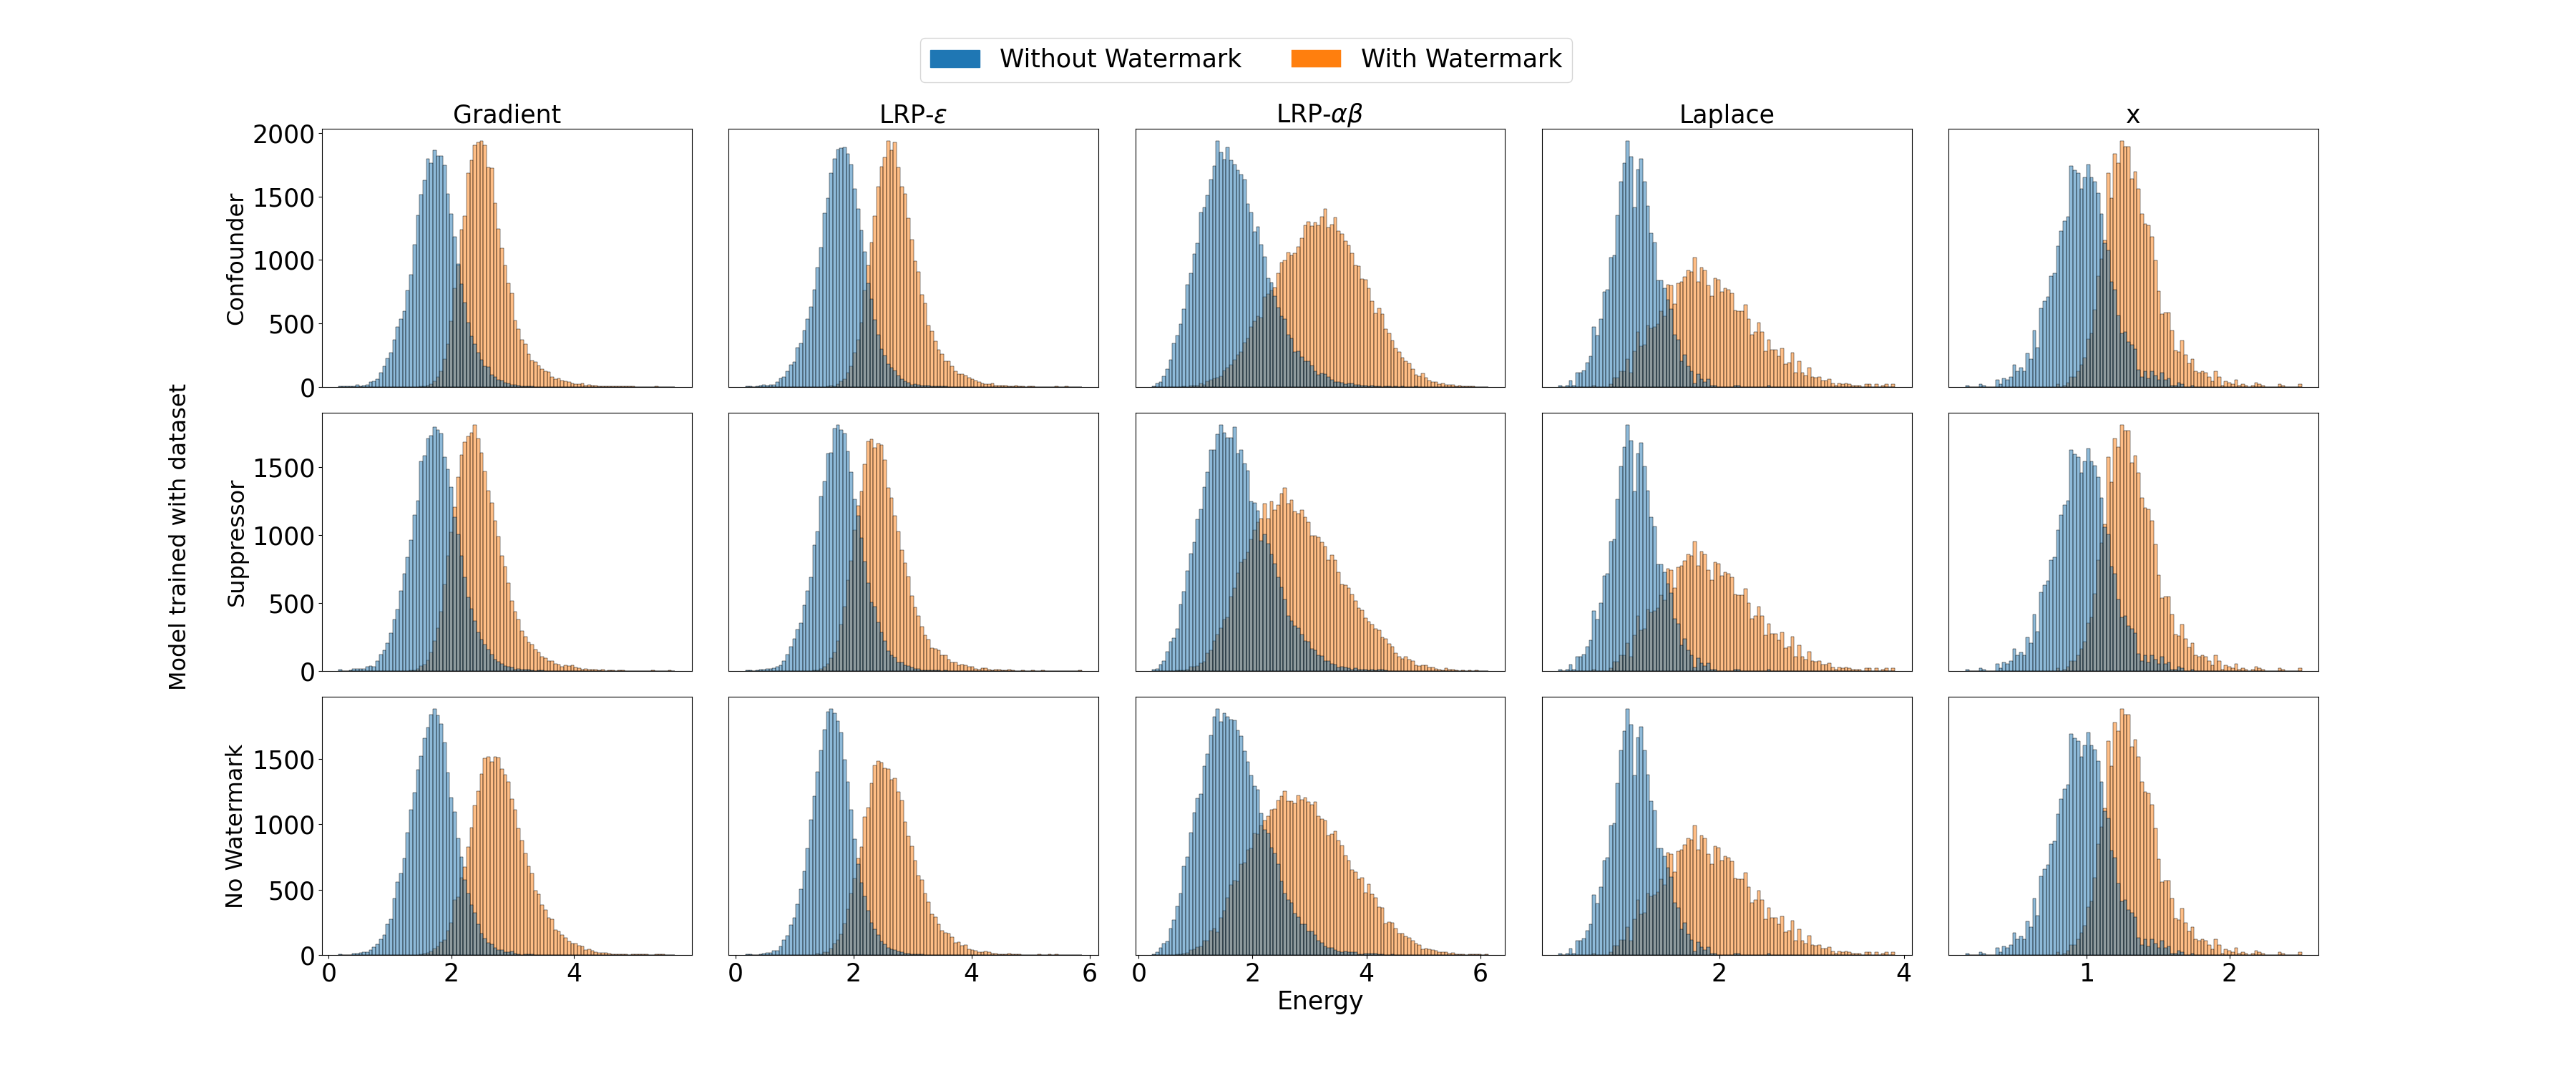

In [28]:
method_inds = [1,3,4,5,7]

fig, axs = plt.subplots(3, len(method_inds), figsize=(36, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
font_size=25
plt.rcParams['font.size'] = font_size
plt.rc('axes', titlesize=font_size) #title


for i in range(3): #model
#     for j in range(8): #method
    j = 0
    for method_ind in method_inds: #method
        #ex: train_energy[method][train][variant]
        g=sns.histplot(ax=axs[i, j],data=[train_energy[method_ind][i][0],train_energy[method_ind][i][1]],bins=100)
        axs[i, j].legend([],[], frameon=False)
        axs[i,j].set_ylabel('')
#         axs[i,j].set_ylim(0,200)
        
        if i!=2:
            axs[i,j].set_xticks([])
            
        if j!=0:
            axs[i,j].set_yticks([])
            
        j+=1
        
#     axs[i,0].set_xlim(0, 5)
#     axs[i,1].set_xlim(0, 5)
#     axs[i,2].set_xlim(0, 5)
#     axs[i,3].set_xlim(0, 5)
    
axs[0,0].legend(['Without Watermark', 'With Watermark'],loc='upper center', bbox_to_anchor=(2.5, 1.4), ncol=2)
leg = axs[0,0].get_legend()
leg.legendHandles[0].set_color(sns.color_palette()[0])
leg.legendHandles[1].set_color(sns.color_palette()[1])
# axs[0,0].title.set_text('Deconv')
axs[0,0].title.set_text('Gradient')
# axs[0,2].title.set_text('GradientSHAP')
axs[0,1].title.set_text(r'LRP-$\epsilon$')
# axs[0,3].title.set_text('LIME')
axs[0,2].title.set_text(r'LRP-$\alpha$$\beta$')
axs[0,3].title.set_text('Laplace')
# axs[0,6].title.set_text('Sobel')
axs[0,4].title.set_text('x')

plt.figtext(0.07,0.5,"Model trained with dataset", va="center", ha="center", size=font_size-2,rotation='vertical')
axs[0,0].set_ylabel('Confounder', size=font_size-2)
axs[1,0].set_ylabel('Suppressor', size=font_size-2)
axs[2,0].set_ylabel('No Watermark', size=font_size-2)

axs[2,2].set_xlabel('Energy', size=font_size)
# axs[2,3].xaxis.set_label_coords(1.15,-0.15)
# plt.savefig('energy_plot_hires_reduced.png', bbox_inches='tight', dpi=300)

## Energy differences
- Calculate sample-wise difference between watermark and no watermark energy

In [20]:
train_energy=[]
methods = ['deconv', 'int_grads', 'shap', 'lrp', 'lrp_ab'] # lime just nan values
# methods = ['deconv', 'int_grads', 'shap', 'lrp']
n_test = 3000

diff_conf = {}
diff_sup = {}
diff_no = {}

for method in methods:
    diff_conf[method] = (0,0)
    diff_sup[method] = (0,0)
    diff_no[method] = (0,0)
    
    diff_conf_list = []
    diff_sup_list = []
    diff_no_list = []
    
    for model_ind in range(10):
        file = open(f'energy_water_conf_comb_pred_{model_ind}.pickle', 'rb')
        energy_water_conf = pickle.load(file)

        file = open(f'energy_water_sup_comb_pred_{model_ind}.pickle', 'rb')
        energy_water_sup = pickle.load(file)

        file = open(f'energy_water_no_comb_pred_{model_ind}.pickle', 'rb')
        energy_water_no = pickle.load(file)

        file = open(f'energy_no_water_conf_comb_pred_{model_ind}.pickle', 'rb')
        energy_no_water_conf = pickle.load(file)

        file = open(f'energy_no_water_sup_comb_pred_{model_ind}.pickle', 'rb')
        energy_no_water_sup = pickle.load(file)

        file = open(f'energy_no_water_no_comb_pred_{model_ind}.pickle', 'rb')
        energy_no_water_no = pickle.load(file)

        
        for i in range(n_test):
            diff_conf_list.append(energy_water_conf[method][i] - energy_no_water_conf[method][i])
            diff_sup_list.append(energy_water_sup[method][i] - energy_no_water_sup[method][i])
            diff_no_list.append(energy_water_no[method][i] - energy_no_water_no[method][i])
            
    
    diff_conf[method] = (np.mean(diff_conf_list), np.std(diff_conf_list))
    diff_sup[method] = (np.mean(diff_sup_list), np.std(diff_sup_list))
    diff_no[method] = (np.mean(diff_no_list), np.std(diff_no_list))

In [21]:
diff_conf

{'deconv': (0.21061336355817178, 0.19930336895685305),
 'int_grads': (0.7607174598373483, 0.3177967412989445),
 'shap': (0.7564631177356392, 0.33095723697245916),
 'lrp': (0.8233381501480436, 0.3732451572253683),
 'lrp_ab': (1.4007541766414462, 0.7045024083199708)}

In [22]:
diff_sup

{'deconv': (0.061716865071412684, 0.18979628892328632),
 'int_grads': (0.6430796205023287, 0.32997672658247523),
 'shap': (0.6344690012968255, 0.3361821680729805),
 'lrp': (0.6268926675009112, 0.3490495611985246),
 'lrp_ab': (1.006206490453659, 0.682590636102803)}

In [23]:
diff_no

{'deconv': (0.34600087012027536, 0.2638469258015764),
 'int_grads': (1.0993945553109534, 0.48269347114165234),
 'shap': (1.069874263838313, 0.48749588277328315),
 'lrp': (0.9907739152504563, 0.4724843023920232),
 'lrp_ab': (1.196897817111365, 0.7895539338730372)}

In [13]:
split = 0
file = open(f'./energies/energy_water_conf_pred_{split}.pickle', 'rb')
energy_water_conf = pickle.load(file)

In [16]:
len(energy_water_conf['deconv'])

9000

## What's going on with LRP?

In [25]:
energy_water_conf={'lrp':[]}
energy_water_sup={'lrp':[]}
energy_water_no={'lrp':[]}

model_conf=load_trained('./cnn_conf_0.pt').to(device)
model_sup=load_trained('./cnn_sup_0.pt').to(device)
model_no=load_trained('./cnn_no_0.pt').to(device)
rgb_weights = [0.2989, 0.5870, 0.1140]
n_test = 1000

folder=os.getcwd()+'/images'
print(folder)
t0=time.time()
for i,w_image in enumerate(watermark_dataset[:n_test]):
    image=w_image[0]
    target=w_image[1]
    
    example=torch.tensor(image).unsqueeze(0).to(device,dtype=torch.float)
    
#     a_conf_w,_=plot_atts(example,model_conf,target)
# #     print(a_conf_w)
#     a_sup_w,_=plot_atts(example,model_sup,target)
#     a_no_w,_=plot_atts(example,model_no,target)
    
    
#     lime_att_conf=np.transpose(Lime(model_conf).attribute(example,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
#     grayscale_att_lime_conf = np.dot(lime_att_conf[...,:3], rgb_weights)
    
#     lime_att_sup=np.transpose(Lime(model_sup).attribute(example,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
#     grayscale_att_lime_sup = np.dot(lime_att_sup[...,:3], rgb_weights)
    
#     lime_att_no=np.transpose(Lime(model_no).attribute(example,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
#     grayscale_att_lime_no = np.dot(lime_att_no[...,:3], rgb_weights)

    lrp_att_conf = lrp(torch.tensor(example),model_conf,device)
    lrp_att_sup = lrp(torch.tensor(example),model_sup,device)
    lrp_att_no = lrp(torch.tensor(example),model_no,device)
    
    for method in list(energy_water_conf.keys()):
        energy_water_conf[method].append(energy(abs(lrp_att_conf)))
        energy_water_sup[method].append(energy(abs(lrp_att_sup)))
        energy_water_no[method].append(energy(abs(lrp_att_no)))

    if i%100==0:
        print(f'{i} out of {len(watermark_dataset)}')
        print(time.time()-t0)
        t0=time.time()
                
# energy_no_water_conf={'lime':[]}
# energy_no_water_sup={'lime':[]}
# energy_no_water_no={'lime':[]}

# t0=time.time()
# for i,w_image in enumerate(no_watermark_dataset[:n_test]):
#     image=w_image[0]
#     target=w_image[1]
    
#     example=torch.tensor(image).unsqueeze(0).to(device,dtype=torch.float)
    
#     a_conf_nw,_=plot_atts(example,model_confounder,target)
#     a_sup_nw,_=plot_atts(example,model_supressor,target)
#     a_no_nw,_=plot_atts(watermark_example,model_no_water,target)
    
#     for method in list(energy_water_conf.keys()):
#         energy_no_water_conf[method].append(energy(a_conf_nw[method]))
#         energy_no_water_sup[method].append(energy(a_sup_nw[method]))
#         energy_no_water_no[method].append(energy(a_no_nw[method]))
    
#     if i%100==0:
#         print(f'{i} out of {len(no_watermark_dataset)}')
#         print(time.time()-t0)
#         t0=time.time()


C:\Users\clark01\Documents\braindata\debugging_xai/images


C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 out of 3000
0.8313050270080566
100 out of 3000
86.19651126861572
200 out of 3000
87.2606840133667
300 out of 3000
81.4245810508728
400 out of 3000
85.14658379554749
500 out of 3000
84.24611473083496
600 out of 3000
86.25528383255005
700 out of 3000
85.3119580745697
800 out of 3000
87.84645581245422
900 out of 3000
85.25251030921936


(3, 128, 128)
torch.Size([1, 3, 128, 128])


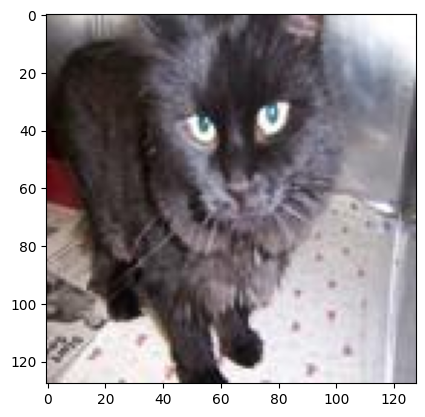

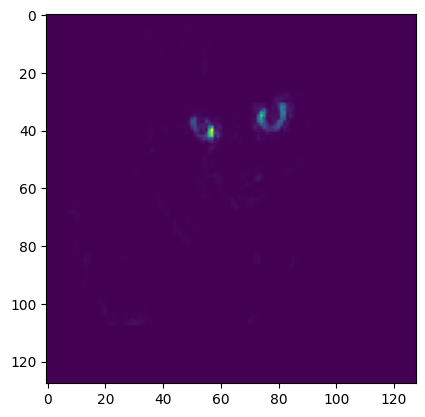

In [14]:
# def lrp(data,model,device):
#     # create a composite instance
#     #composite = EpsilonPlusFlat()
#     composite = EpsilonAlpha2Beta1()

#     # use the following instead to ignore bias for the relevance
#     # composite = EpsilonPlusFlat(zero_params='bias')

#     # make sure the input requires a gradient
#     data.requires_grad = True

#     # compute the output and gradient within the composite's context
#     with composite.context(model) as modified_model:
#         modified_model=modified_model.to(device)
#         output = modified_model(data.to(device))
#         # gradient/ relevance wrt. class/output 0
#         output.backward(gradient=torch.eye(2)[[0]].to(device))
#         # relevance is not accumulated in .grad if using torch.autograd.grad
#         # relevance, = torch.autograd.grad(output, input, torch.eye(10)[[0])

#     # gradient is accumulated in input.grad
#     att=abs(data.grad.detach().cpu().squeeze().numpy().transpose(1,2,0))

#     rgb_weights = [0.2989, 0.5870, 0.1140]
#     grayscale_att_lrp = np.dot(att[...,:3], rgb_weights)

    
#     return grayscale_att_lrp
    



n=2
test_img = no_watermark_dataset[n][0]
print(test_img.shape)
target=no_watermark_dataset[n][1]
# test_img = supressor_test[n][0]
# target=supressor_test[n][1]
transformed_img=torch.tensor(test_img)
input_image = transformed_img.unsqueeze(0)
print(input_image.shape)
data=input_image.to(device,dtype=torch.float)

plt.imshow(input_image.squeeze().to('cpu').numpy().transpose(1,2,0))
plt.figure()
grayscale_att_lrp=lrp(data,model_supressor,device)
plt.imshow(abs(grayscale_att_lrp))
    
    

In [64]:
lime_att_sup=np.transpose(Lime(model_sup).attribute(torch.as_tensor(np.array(watermark_dataset[:100])[:,0], dtype=torch.float64),target=torch.as_tensor(np.array(watermark_dataset[:100])[:,1], dtype=torch.float64)).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
grayscale_att_lime_sup = np.dot(lime_att_sup[...,:3], rgb_weights)

C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [35]:
x = np.linspace(0, int(128*128 - 1), int(128*128/4))
x.shape

(4096,)

In [36]:
x_scaled = np.kron(x, np.ones((2,2)))

In [46]:
x_scaled

array([[0.00000000e+00, 0.00000000e+00, 4.00073260e+00, ...,
        1.63789993e+04, 1.63830000e+04, 1.63830000e+04],
       [0.00000000e+00, 0.00000000e+00, 4.00073260e+00, ...,
        1.63789993e+04, 1.63830000e+04, 1.63830000e+04]])

In [37]:
x_scaled.reshape((128,128))

array([[0.00000000e+00, 0.00000000e+00, 4.00073260e+00, ...,
        2.48045421e+02, 2.52046154e+02, 2.52046154e+02],
       [2.56046886e+02, 2.56046886e+02, 2.60047619e+02, ...,
        5.04092308e+02, 5.08093040e+02, 5.08093040e+02],
       [5.12093773e+02, 5.12093773e+02, 5.16094505e+02, ...,
        7.60139194e+02, 7.64139927e+02, 7.64139927e+02],
       ...,
       [1.56188601e+04, 1.56188601e+04, 1.56228608e+04, ...,
        1.58669055e+04, 1.58709062e+04, 1.58709062e+04],
       [1.58749070e+04, 1.58749070e+04, 1.58789077e+04, ...,
        1.61229524e+04, 1.61269531e+04, 1.61269531e+04],
       [1.61309538e+04, 1.61309538e+04, 1.61349546e+04, ...,
        1.63789993e+04, 1.63830000e+04, 1.63830000e+04]])

<IPython.core.display.Javascript object>


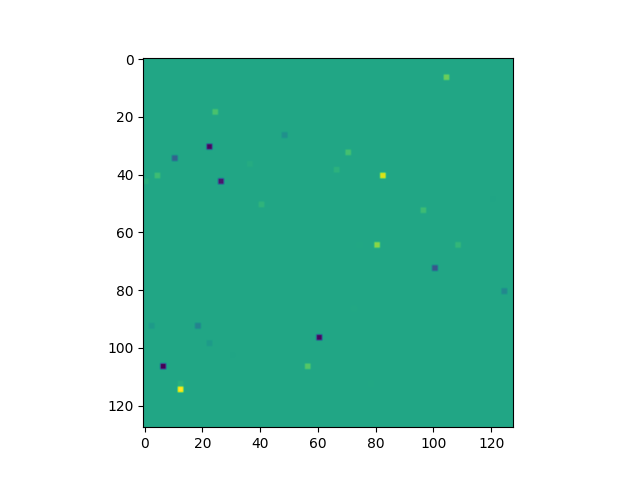

NameError: name 'x_scaled' is not defined

In [37]:
%matplotlib notebook
fig, axs = plt.subplots()
axs.imshow(x_scaled.reshape((128,128)))
plt.show()

In [19]:


test = np.zeros((4096, 2, 2))
for i in range(4096):
    test[i] = [[i,i],[i,i]]

In [29]:
np.squeeze(test.reshape((64,64,2,2))).shape

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [99]:
feature_mask = np.zeros((128,128))
j=0
k=0
for i in range(4096):
#     feature_mask[j,k]=i
#     feature_mask[j+1,k] = i
#     feature_mask[j,k+1] = i
#     feature_mask[j+1,k+1] = i
    feature_mask[j:j+2,k:k+2] = i
    k+=2
    if k == 128:
        k=0
        j+=2

In [100]:
torch.tensor(feature_mask, dtype=int)

tensor([[   0,    0,    1,  ...,   62,   63,   63],
        [   0,    0,    1,  ...,   62,   63,   63],
        [  64,   64,   65,  ...,  126,  127,  127],
        ...,
        [3968, 3968, 3969,  ..., 4030, 4031, 4031],
        [4032, 4032, 4033,  ..., 4094, 4095, 4095],
        [4032, 4032, 4033,  ..., 4094, 4095, 4095]])

In [97]:
feature_mask_4by4 = np.zeros((128,128))
j=0
k=0
for i in range(1024):
#     feature_mask[j,k]=i
#     feature_mask[j+1,k] = i
#     feature_mask[j,k+1] = i
#     feature_mask[j+1,k+1] = i
    feature_mask_4by4[j:j+4,k:k+4] = i
    k+=4
    if k == 128:
        k=0
        j+=4

In [98]:
torch.tensor(feature_mask_4by4, dtype=int)

tensor([[   0,    0,    0,  ...,   31,   31,   31],
        [   0,    0,    0,  ...,   31,   31,   31],
        [   0,    0,    0,  ...,   31,   31,   31],
        ...,
        [ 992,  992,  992,  ..., 1023, 1023, 1023],
        [ 992,  992,  992,  ..., 1023, 1023, 1023],
        [ 992,  992,  992,  ..., 1023, 1023, 1023]])

In [116]:
data = torch.tensor(watermark_dataset[1500][0]).unsqueeze(0).to(device,dtype=torch.float)
# data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
target = watermark_dataset[1500][1]
model = load_model('./cnn_conf_0.pt')

In [117]:
lime_obj = Lime(model)
rgb_weights = [0.2989, 0.5870, 0.1140]  

In [118]:
lime_att = np.transpose(lime_obj.attribute(data,target=target, n_samples=1000, feature_mask=torch.tensor(feature_mask, dtype=int)).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
lime_att_4by4 = np.transpose(lime_obj.attribute(data,target=target, n_samples=1000, feature_mask=torch.tensor(feature_mask_4by4, dtype=int)).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
lime_att_no_mask = np.transpose(lime_obj.attribute(data,target=target, n_samples=1000).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()

C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\attr\_core\lime.py:1102: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  "Attempting to construct interpretable model with > 10000 features."


In [119]:
grayscale_data = abs(np.dot(np.transpose(data.squeeze(), (1,2,0))[...,:3], rgb_weights))
grayscale_lime_att = abs(np.dot(lime_att[...,:3], rgb_weights))
grayscale_lime_att_4by4 = abs(np.dot(lime_att_4by4[...,:3], rgb_weights))
grayscale_lime_att_no_mask = abs(np.dot(lime_att_no_mask[...,:3], rgb_weights))

<IPython.core.display.Javascript object>


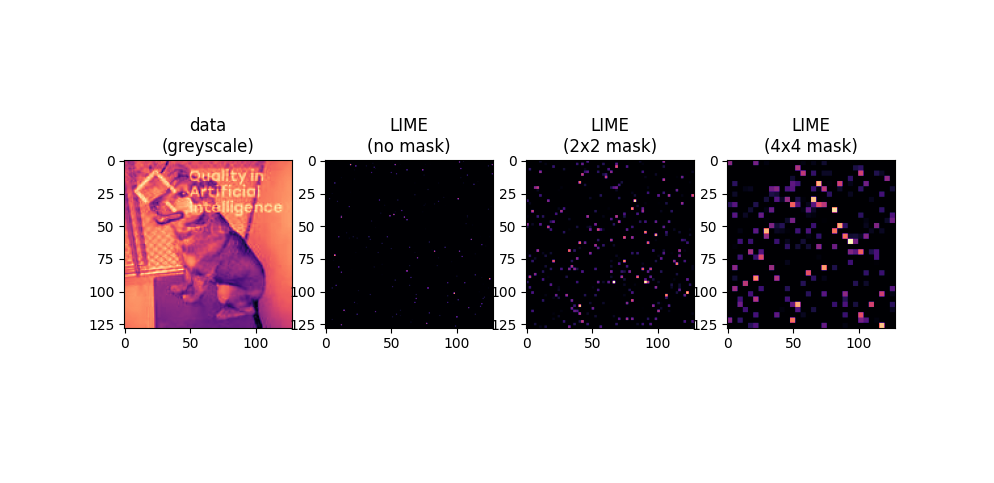

In [120]:
fig,axs = plt.subplots(1,4)
axs[0].imshow(grayscale_data, cmap='magma')
axs[1].imshow(grayscale_lime_att_no_mask, cmap='magma')
axs[2].imshow(grayscale_lime_att, cmap='magma')
axs[3].imshow(grayscale_lime_att_4by4, cmap='magma')

axs[0].set_title('data\n(greyscale)')
axs[1].set_title('LIME\n(no mask)')
axs[2].set_title('LIME\n(2x2 mask)')
axs[3].set_title('LIME\n(4x4 mask)')
plt.show()